In [1]:
import pandas as pd 
import numpy as np 
import jieba
import paddlenlp
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# #from keras.preprocessing.sequence import pad_sequences
# # from keras.models import Sequential
# # from keras.layers import Embedding, LSTM, Dense
import requests
import urllib3
import json
import sys
import re
from pylab import *
from tqdm import tqdm
mpl.rcParams['font.sans-serif'] = ['SimHei']
import os 

In [2]:
# def read_csv(file_path):
#     return pd.read_csv(file_path)

# def tokenize(text):
#     return list(jieba.cut(text))

In [5]:
# ak = 'UIPpUw5Tsytb51TE3wN6Kve2'
# sk = 'V8fSJNvzJ7ZwB39bVIrHSf9eHbpDhCcZ'
 
# host = 'https://aip.baidubce.com/oauth/2.0/token?grant_type=client_credentials&client_id={}&client_secret={}'.format(ak,sk)
 
# res = requests.post(host)
# print(res.text)

In [6]:
# access_token = "24.aab2c2d5ed9f4064f10c6883578d2f25.2592000.1713019534.282335-56521734"
# http = urllib3.PoolManager()

# url = 'https://aip.baidubce.com/rpc/2.0/nlp/v1/sentiment_classify?access_token=' + access_token


In [2]:
# Ernie 模型分词器
from paddlenlp.transformers import ErnieTokenizer
# Ernie 文本分类模型
from paddlenlp.transformers import ErnieForSequenceClassification
# Paddle 加载数据集
from paddlenlp.datasets import load_dataset
# Paddle 数据加载器
from paddle.io import DataLoader
from paddlenlp.transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import paddle
import paddle.nn as nn
# 进度条
from tqdm import tqdm
# 动态学习率
from paddlenlp.transformers import LinearDecayWithWarmup
from paddlenlp.transformers import ConstScheduleWithWarmup
# 优化方法
from paddle.optimizer import AdamW
from paddle.optimizer import SGD
from paddle.optimizer import Momentum
# 损失函数
from paddle.nn import CrossEntropyLoss
# 评估函数
from paddle.metric import Accuracy
# 功能函数
import paddle.nn.functional as F
# 读写目录
import glob
import math
from sklearn.metrics import confusion_matrix, roc_curve,auc,f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# 预训练模型参数
# checkpoint = 'ernie-3.0-medium-zh'
# checkpoint = 'bert-wwm-chinese'
# checkpoint = 'gpt-cpm-large-cn'
checkpoint = 'ernie-3.0-mini-zh'

# 设置默认计算设备, 对于 GPU 版本的 Paddle 默认设备就是 GPU
paddle.device.set_device('gpu:0')

Place(gpu:0)

In [3]:
paddle.utils.run_check()

Running verify PaddlePaddle program ... 


W0508 08:07:49.295755 64344 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.2
W0508 08:07:49.300532 64344 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


PaddlePaddle works well on 1 GPU.
PaddlePaddle works well on 1 GPUs.
PaddlePaddle is installed successfully! Let's start deep learning with PaddlePaddle now.


In [5]:
df = pd.read_csv("/home/aistudio/data/data_train_last_balanced.csv")
mask = df['标题'].str.contains('\t|\n', regex=True, na=False)
df = df[~mask]
df = df.loc[:,['标题','情感']]
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42,stratify=df['情感'])
train_df.to_csv("train.txt",sep='\t',index=False,header=False)
valid_df.to_csv("dev.txt",sep='\t',index=False,header=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/aistudio/data/data_train_last_balanced.csv'

In [5]:
df_2 = pd.read_csv("/home/aistudio/data/data_train_two_balanced.csv")
mask = df_2['标题'].str.contains('\t|\n', regex=True, na=False)
df_2 = df_2[~mask]
df_2 = df_2.loc[:,['标题','情感']]
train_df_2, valid_df_2 = train_test_split(df_2, test_size=0.2, random_state=42,stratify=df_2['情感'])
train_df_2.to_csv("train2.txt",sep='\t',index=False,header=False)
valid_df_2.to_csv("dev2.txt",sep='\t',index=False,header=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/aistudio/data/data_train_two_balanced.csv'

In [4]:
from paddlenlp.datasets import MapDataset

def read(data_path):
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')  # 假设文本和标签由tab分隔
            if len(parts) == 2:  # 确保每行都是文本跟随标签
                yield {'text': parts[0], 'label': int(parts[1])}
            else:
                continue  # 忽略格式不正确的行

def load_my_dataset(data_path):
    # 使用MapDataset加载数据
    return MapDataset(list(read(data_path)))

In [7]:
# data_path为read()方法的参数
train_ds = load_my_dataset(data_path='train.txt')
dev_ds = load_my_dataset(data_path='dev.txt')

In [5]:
train_ds_2 = load_my_dataset(data_path='train2.txt')
dev_ds_2 = load_my_dataset(data_path='dev2.txt')

In [8]:
for i in range(5):
    print(train_ds[i])

{'text': '这个死垃圾垃圾', 'label': 0}
{'text': '大家发财，我卖了就涨起来了[好困惑]', 'label': 0}
{'text': '果然开始涨了，看好闻泰[看多][看多][看多]', 'label': 2}
{'text': '尾盘跳水，杀伤力很大', 'label': 0}
{'text': '马上跌到16.88元了，快了！', 'label': 0}


In [5]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
def load_data(batch_size=8):
    def collate_fn(batch_data):
        batch_inputs = []
        batch_labels = []
        # data 格式:
        for data in batch_data:
            batch_inputs.append(data['text'])
            batch_labels.append(data['label'])
        # 文本数据分词、编码
        batch_inputs = tokenizer(batch_inputs,
                                 padding=True,
                                 truncation=True,
                                 max_length=510,
                                 add_special_tokens=True,
                                 return_tensors='pd')
        # 标签转换为 Paddle 张量
        batch_labels = paddle.to_tensor(batch_labels)
        return batch_inputs, batch_labels

    params = {'batch_size': batch_size, 'collate_fn': collate_fn}
    train_dataloader = DataLoader(train_ds, **params, shuffle=False)
    dev_dataloader = DataLoader(dev_ds, **params, shuffle=False)
    return train_dataloader, dev_dataloader

def test01():
    train_dataloader, _ = load_data()
    for batch_inputs, batch_labels in tqdm(train_dataloader):
        print('标签数量:', len(batch_labels))
        print('输入编码:', batch_inputs['input_ids'])
        break

[2024-05-08 08:07:59,362] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.tokenizer.ErnieTokenizer'> to load 'ernie-3.0-mini-zh'.
[2024-05-08 08:07:59,366] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-3.0-mini-zh/ernie_3.0_mini_zh_vocab.txt
[2024-05-08 08:07:59,397] [    INFO] - tokenizer config file saved in /home/aistudio/.paddlenlp/models/ernie-3.0-mini-zh/tokenizer_config.json
[2024-05-08 08:07:59,401] [    INFO] - Special tokens file saved in /home/aistudio/.paddlenlp/models/ernie-3.0-mini-zh/special_tokens_map.json


In [ ]:
def remove_stopwords(text, stopwords):
    words = jieba.cut(text, use_paddle=True)
    filtered_words = [word for word in words if word not in stopwords]
    return " ".join(filtered_words)

# 加载停用词
with open("/home/aistudio/data/stopwords_cn.txt", "r", encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

def preprocess_dataset(dataset):
    clean_dataset = []
    for data in dataset:
        text = data['text']
        label = data['label']
        cleaned_text = remove_stopwords(text, stopwords)
        clean_dataset.append({'text': cleaned_text, 'label': label})
    return clean_dataset
print("原始数据样本:", train_ds[0])

# 对数据集进行预处理
train_data_clean = preprocess_dataset(train_ds)
dev_data_clean = preprocess_dataset(dev_ds)
print("处理后的数据样本:", train_data_clean[0])
def load_data_stopwords(batch_size=8):
    def collate_fn(batch_data):
        batch_inputs = []
        batch_labels = []
        for data in batch_data:
            batch_inputs.append(data['text'])
            batch_labels.append(data['label'])
        batch_inputs = tokenizer(batch_inputs,
                                 padding=True,
                                 truncation=True,
                                 max_length=510,
                                 add_special_tokens=True,
                                 return_tensors='pd')
        batch_labels = paddle.to_tensor(batch_labels)
        return batch_inputs, batch_labels

    params = {'batch_size': batch_size, 'collate_fn': collate_fn}
    train_dataloader_3 = DataLoader(train_data_clean, **params, shuffle=False)
    dev_dataloader_3 = DataLoader(dev_data_clean, **params, shuffle=False)
    return train_dataloader_3, dev_dataloader_3

train_dataloader_3, dev_dataloader_3 = load_data_stopwords(batch_size=8)
for batch_inputs, batch_labels in train_dataloader_3:
    print('批处理数据样本:', batch_inputs['input_ids'][0])  # 显示第一个批处理的样本
    print('对应标签:', batch_labels[0])
    break

原始数据样本: {'text': '已经启动，上车上车', 'label': 2}
处理后的数据样本: {'text': '启动 上车 上车', 'label': 2}


Exception in thread Thread-10:
Traceback (most recent call last):
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddlenlp/transformers/tokenizer_utils_base.py", line 725, in convert_to_tensors
    tensor = as_tensor(value)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py", line 546, in to_tensor
    return _to_tensor_non_static(data, dtype, place, stop_gradient)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py", line 411, in _to_tensor_non_static
    stop_gradient=stop_gradient,
OSError: (External) CUDA error(719), unspecified launch failure. 
  [Hint: Please search for the error code(719) on website (https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html#group__CUDART__TYPES_1g3f51e3575c2178246db0a94a430e0038) to get Nvidia's official solution and advice about CUDA Error.] (at /paddle/paddle/phi/backends/gpu/cuda/cuda_info.cc:259)


Duri

In [6]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
def load_data_2(batch_size=8):
    def collate_fn(batch_data):
        batch_inputs = []
        batch_labels = []
        # data 格式:
        for data in batch_data:
            batch_inputs.append(data['text'])
            batch_labels.append(data['label'])
        # 文本数据分词、编码
        batch_inputs = tokenizer(batch_inputs,
                                 padding=True,
                                 truncation=True,
                                 max_length=510,
                                 add_special_tokens=True,
                                 return_tensors='pd')
        # 标签转换为 Paddle 张量
        batch_labels = paddle.to_tensor(batch_labels)
        return batch_inputs, batch_labels

    params = {'batch_size': batch_size, 'collate_fn': collate_fn}
    train_dataloader_2 = DataLoader(train_ds_2, **params, shuffle=False)
    dev_dataloader_2 = DataLoader(dev_ds_2, **params, shuffle=False)
    return train_dataloader_2, dev_dataloader_2

def test02():
    train_dataloader_2, _ = load_data()
    for batch_inputs, batch_labels in tqdm(train_dataloader_2):
        print('标签数量:', len(batch_labels))
        print('输入编码:', batch_inputs['input_ids'])
        break

[2024-05-07 23:14:28,027] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.tokenizer.ErnieTokenizer'> to load 'ernie-3.0-mini-zh'.
[2024-05-07 23:14:28,031] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-3.0-mini-zh/ernie_3.0_mini_zh_vocab.txt
[2024-05-07 23:14:28,058] [    INFO] - tokenizer config file saved in /home/aistudio/.paddlenlp/models/ernie-3.0-mini-zh/tokenizer_config.json
[2024-05-07 23:14:28,060] [    INFO] - Special tokens file saved in /home/aistudio/.paddlenlp/models/ernie-3.0-mini-zh/special_tokens_map.json


In [10]:
test01()

  0%|          | 0/1277 [00:00<?, ?it/s]

标签数量: 8
输入编码: Tensor(shape=[8, 27], dtype=int64, place=Place(gpu:0), stop_gradient=True,
       [[1  , 47 , 27 , 593, 2229, 2231, 2229, 2231, 2  , 0  , 0  , 0  , 0  , 0  ,
         0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  ],
        [1  , 19 , 50 , 34 , 625, 4  , 75 , 1225, 15 , 113, 2394, 200, 61 , 15 ,
         9475, 170, 977, 2098, 12068, 2  , 0  , 0  , 0  , 0  , 0  , 0  , 0  ],
        [1  , 228, 187, 88 , 440, 2394, 15 , 4  , 335, 170, 877, 1287, 9475, 335,
         65 , 12068, 9475, 335, 65 , 12068, 9475, 335, 65 , 12068, 2  , 0  , 0  ],
        [1  , 1235, 966, 1498, 101, 4  , 780, 767, 90 , 321, 19 , 2  , 0  , 0  ,
         0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  ],
        [1  , 466, 28 , 2357, 45 , 1227, 42 , 2803, 183, 15 , 4  , 532, 15 , 12044,
         2  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  ],
        [1  , 48 , 22 , 2052, 2  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  , 0  ,
         0  , 0  , 0  , 0  , 0  ,

  0%|          | 0/1277 [00:00<?, ?it/s]


In [16]:
test02()

  0%|          | 0/1458 [00:00<?, ?it/s]

标签数量: 8
输入编码: Tensor(shape=[8, 41], dtype=int64, place=Place(gpu:0), stop_gradient=True,
       [[1   , 265 , 60  , 1087, 70  , 4   , 28  , 320 , 28  , 320 , 2   , 0   ,
         0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   ,
         0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   ,
         0   , 0   , 0   , 0   , 0   ],
        [1   , 837 , 1039, 276 , 505 , 10  , 837 , 1039, 303 , 9   , 8   , 653 ,
         58  , 46  , 143 , 5   , 104 , 4   , 59  , 536 , 10  , 303 , 9   , 8   ,
         54  , 53  , 230 , 46  , 143 , 5   , 104 , 4   , 297 , 54  , 53  , 230 ,
         60  , 372 , 9   , 129 , 2   ],
        [1   , 7   , 502 , 882 , 59  , 536 , 4   , 837 , 242 , 142 , 449 , 424 ,
         52  , 349 , 134 , 19  , 185 , 620 , 2   , 0   , 0   , 0   , 0   , 0   ,
         0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   , 0   ,
         0   , 0   , 0   , 0   , 0   ],
        [1   , 181 , 125 , 48  , 52  , 32  , 2394, 1025, 12043

  0%|          | 0/1458 [00:00<?, ?it/s]


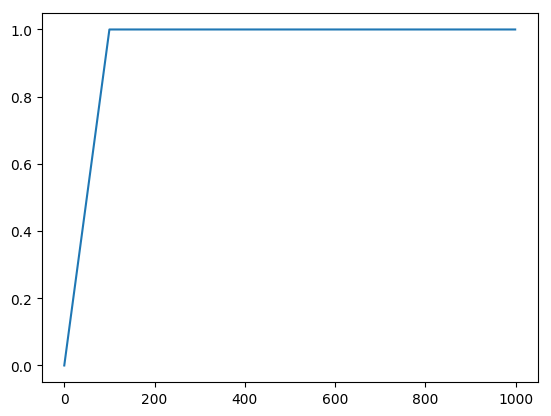

In [12]:
from paddlenlp.transformers import ConstScheduleWithWarmup
import matplotlib.pyplot as plt


if __name__ == '__main__':

    scheduler = ConstScheduleWithWarmup(learning_rate=1,
                                        total_steps=1000, 
                                        warmup=0.1)
    learning_rates = []
    for _ in range(1000):
        learning_rates.append(scheduler.get_lr())
        scheduler.step()

    plt.plot(range(1000), learning_rates)
    plt.show()

In [13]:
def plot_roc_curve(y_true, y_score, n_classes=3):
    # 计算每一类的ROC
    y_true = label_binarize(y_true, classes=[i for i in range(n_classes)])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

In [16]:
# paddle.save(model.state_dict(), 'model_state.pdparams')
# paddle.save(optimizer.state_dict(), 'optimizer.optparams')
# paddle.save(scheduler.state_dict(), 'scheduler.optparams')
# tokenizer.save_pretrained('./')
# import json

# model_config = model.get_config()  # 假设这个方法返回模型配置的字典
# with open('model_config.json', 'w') as f:
#     json.dump(model_config, f)
# for epoch in range(total_epochs):
#     # ...训练过程...
#     if should_save(epoch):  # 自定义的保存条件
#         paddle.save(model.state_dict(), f'senti-{epoch}-{score}.pdparams')

In [14]:
import paddle.nn as nn
class CustomDropoutLayer(nn.Layer):
    def __init__(self, dropout_prob=0.5):
        super(CustomDropoutLayer, self).__init__()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, inputs):
        return {key: self.dropout(val) if key == 'input_ids' and val.dtype in [paddle.float32, paddle.float64] else val for key, val in inputs.items()}


In [13]:
def train_model_adam(checkpoint, num_epoch, learning_rate, batch_size, accumulation_steps):

    # **************************初始化训练对象***************************
    # 加载数据集
    train_set, valid_set = load_data()
    # 初始化模型
    estimator = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                               num_classes=3)

    # 动态学习率
    scheduler = LinearDecayWithWarmup(learning_rate=learning_rate,
                                        total_steps=len(train_set)*num_epoch,
                                        warmup=0.1
                                        )
    # scheduler = ConstScheduleWithWarmup(learning_rate=learning_rate,
    #                                 total_steps=len(train_set)*num_epoch,
    #                                 warmup=0.1
    #                                 )
    # 优化方法
    optimizer = AdamW(parameters=estimator.parameters(),
                      learning_rate=scheduler,weight_decay=0.1)
    # 损失函数
    criterion = CrossEntropyLoss(use_softmax=True)
    # 评估方法
    metric = Accuracy()
    # 初始化存储数组
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    f1_scores = []
    auc_scores = []
    all_preds = []
    all_labels = []
    all_probs = []
    
    custom_dropout = CustomDropoutLayer(dropout_prob=0.5)
    # 训练逻辑
    for epoch_idx in range(num_epoch):

        # **************************训练集训练*************************
        optimizer.clear_grad()
        progress = tqdm(range(len(train_set)),
                        desc='epoch %2d' % (epoch_idx + 1))
        total_loss = 0.0  # 轮次损失
        stage_loss = 0.0  # 阶段损失
        for iter_idx, (batch_inputs, batch_labels) in enumerate(train_set):
            batch_inputs = custom_dropout(batch_inputs)
            # 模型计算
            outputs = estimator(**batch_inputs)
            # 损失计算
            loss = criterion(outputs, batch_labels)
            # 训练信息
            total_loss += loss.item() * len(batch_labels)
            stage_loss += loss.item() * len(batch_labels)
            # 梯度计算
            (loss / accumulation_steps).backward()

            # 参数更新
            if iter_idx % accumulation_steps == 0:
                optimizer.step()
                optimizer.clear_grad()
                progress.set_description('epoch % 2d stage loss %.5f'
                                         % (epoch_idx + 1, stage_loss))
                stage_loss = 0.0
            # 学习率更新
            scheduler.step()
            # 进度条更新
            progress.update()

        # 设置轮次损失
        progress.set_description('epoch % 2d total loss %.5f'
                                 % (epoch_idx + 1, total_loss))
        average_loss = total_loss / len(train_set)
        train_losses.append(average_loss)
        # 关闭进度条
        progress.close()

        # **************************验证集评估*************************
        with paddle.no_grad():
            total_valid_loss = 0
            progress = tqdm(range(len(valid_set)), desc='evaluate')
            metric.reset()

            for iter_idx, (batch_inputs, batch_labels) in enumerate(valid_set):
                # 模型计算
                outputs = estimator(**batch_inputs)
                loss = criterion(outputs,batch_labels)
                total_valid_loss += loss.item()* len(batch_labels)
                # 计算概率
                probas = F.softmax(outputs)
                #获取预测标签
                preds = paddle.argmax(probas,axis=1)
                #保存预测和真实标签
                all_preds.extend(preds.numpy())
                all_labels.extend(batch_labels.numpy())
                all_probs.extend(probas.numpy())
                # 标签预测
                correct = metric.compute(probas, batch_labels)
                metric.update(correct)
                
                # 进度条更新
                progress.update()

            f1 = f1_score(all_labels,all_preds,average='weighted')
            f1_scores.append(f1)

            # 设置轮次损失
            acc = metric.accumulate()
            valid_accuracies.append(acc)
            average_valid_loss = total_valid_loss / len(valid_set)
            valid_losses.append(average_valid_loss)
            progress.set_description('evaluate acc %.3f' % acc)
            
            progress.set_description('evaluate valid_loss %.3f' % total_valid_loss)

            # 关闭进度条
            progress.close()

            #模型保存
            model_params = {
            'checkpoint': checkpoint,
            'num_epoch': num_epoch,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'accumulation_steps': accumulation_steps,
            'train_loss': train_losses,
            'valid_loss': valid_losses,
            'valid_accuracy': valid_accuracies,
            'f1_score': f1_scores,
            }
            model_save_dir = 'model/saved_parameters'
            paddle.save(model_params,f'{model_save_dir}_{checkpoint}_lr{learning_rate}_bs{batch_size}_epochs{num_epoch}.pdparams')


    # 在函数的最后，绘制损失和准确率图像
    plt.figure(figsize=(16, 8))

    # 绘制训练损失图像
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses,label='Validation Loss',linestyle='--')
    plt.title('Training and Validation Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制验证准确率图像
    plt.subplot(2, 3, 2)
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    #绘制混淆矩阵
    plt.subplot(2,3,3)
    cm =confusion_matrix(all_labels,all_preds)
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=['Negative_preds', 'Middle_preds', 'Positive_preds'], yticklabels=['Negative_actual', 'Middle_actual', 'Positive_actual'])
    plt.xticks(rotation=45) 
    plt.yticks(rotation=45)
    
    #绘制ROC曲线
    plt.subplot(2,3,4)
    all_probs = np.array(all_probs)
    plot_roc_curve(all_labels,all_probs)


    #绘制F1分数
    plt.subplot(2,3,5)
    plt.plot(f1_scores,label='F1 Score',color='purple')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [33]:
def train_model_adam_2(checkpoint, num_epoch, learning_rate, batch_size, accumulation_steps):

    # **************************初始化训练对象***************************
    # 加载数据集
    train_set, valid_set = load_data_2()
    # 初始化模型
    estimator = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                               num_classes=3)

    # 动态学习率
    scheduler = LinearDecayWithWarmup(learning_rate=learning_rate,
                                        total_steps=len(train_set)*num_epoch,
                                        warmup=0.1
                                        )
    # scheduler = ConstScheduleWithWarmup(learning_rate=learning_rate,
    #                                 total_steps=len(train_set)*num_epoch,
    #                                 warmup=0.1
    #                                 )
    # 优化方法
    optimizer = AdamW(parameters=estimator.parameters(),
                      learning_rate=scheduler,weight_decay=0.1)
    # 损失函数
    criterion = CrossEntropyLoss(use_softmax=True)
    # 评估方法
    metric = Accuracy()
    # 初始化存储数组
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    f1_scores = []
    auc_scores = []
    all_preds = []
    all_labels = []
    all_probs = []
    
    custom_dropout = CustomDropoutLayer(dropout_prob=0.5)
    # 训练逻辑
    for epoch_idx in range(num_epoch):

        # **************************训练集训练*************************
        optimizer.clear_grad()
        progress = tqdm(range(len(train_set)),
                        desc='epoch %2d' % (epoch_idx + 1))
        total_loss = 0.0  # 轮次损失
        stage_loss = 0.0  # 阶段损失
        for iter_idx, (batch_inputs, batch_labels) in enumerate(train_set):
            batch_inputs = custom_dropout(batch_inputs)
            # 模型计算
            outputs = estimator(**batch_inputs)
            # 损失计算
            loss = criterion(outputs, batch_labels)
            # 训练信息
            total_loss += loss.item() * len(batch_labels)
            stage_loss += loss.item() * len(batch_labels)
            # 梯度计算
            (loss / accumulation_steps).backward()

            # 参数更新
            if iter_idx % accumulation_steps == 0:
                optimizer.step()
                optimizer.clear_grad()
                progress.set_description('epoch % 2d stage loss %.5f'
                                         % (epoch_idx + 1, stage_loss))
                stage_loss = 0.0
            # 学习率更新
            scheduler.step()
            # 进度条更新
            progress.update()

        # 设置轮次损失
        progress.set_description('epoch % 2d total loss %.5f'
                                 % (epoch_idx + 1, total_loss))
        average_loss = total_loss / len(train_set)
        train_losses.append(average_loss)
        # 关闭进度条
        progress.close()

        # **************************验证集评估*************************
        with paddle.no_grad():
            total_valid_loss = 0
            progress = tqdm(range(len(valid_set)), desc='evaluate')
            metric.reset()

            for iter_idx, (batch_inputs, batch_labels) in enumerate(valid_set):
                # 模型计算
                outputs = estimator(**batch_inputs)
                loss = criterion(outputs,batch_labels)
                total_valid_loss += loss.item()* len(batch_labels)
                # 计算概率
                probas = F.softmax(outputs)
                #获取预测标签
                preds = paddle.argmax(probas,axis=1)
                #保存预测和真实标签
                all_preds.extend(preds.numpy())
                all_labels.extend(batch_labels.numpy())
                all_probs.extend(probas.numpy())
                # 标签预测
                correct = metric.compute(probas, batch_labels)
                metric.update(correct)
                
                # 进度条更新
                progress.update()

            f1 = f1_score(all_labels,all_preds,average='weighted')
            f1_scores.append(f1)

            # 设置轮次损失
            acc = metric.accumulate()
            valid_accuracies.append(acc)
            average_valid_loss = total_valid_loss / len(valid_set)
            valid_losses.append(average_valid_loss)
            progress.set_description('evaluate acc %.3f' % acc)
            
            progress.set_description('evaluate valid_loss %.3f' % total_valid_loss)

            # 关闭进度条
            progress.close()

            #模型保存
            model_params = {
            'checkpoint': checkpoint,
            'num_epoch': num_epoch,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'accumulation_steps': accumulation_steps,
            'train_loss': train_losses,
            'valid_loss': valid_losses,
            'valid_accuracy': valid_accuracies,
            'f1_score': f1_scores,
            }
            model_save_dir = 'model/saved_parameters'
            paddle.save(model_params,f'{model_save_dir}_model/senti_{checkpoint}_lr{learning_rate}_bs{batch_size}_epochs{num_epoch}.pdparams')
            if not os.path.exists(model_save_dir):
                os.makedirs(model_save_dir)
            estimator.save_pretrained(model_save_dir)
            tokenizer.save_pretrained(model_save_dir)
            paddle.save(optimizer.state_dict(), os.path.join(model_save_dir, 'optimizer.optparams'))
            paddle.save(scheduler.state_dict(), os.path.join(model_save_dir, 'scheduler.optparams'))

    # 在函数的最后，绘制损失和准确率图像
    plt.figure(figsize=(16, 8))

    # 绘制训练损失图像
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses,label='Validation Loss',linestyle='--')
    plt.title('Training and Validation Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制验证准确率图像
    plt.subplot(2, 3, 2)
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    #绘制混淆矩阵
    plt.subplot(2,3,3)
    cm =confusion_matrix(all_labels,all_preds)
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=['Negative_preds', 'Middle_preds', 'Positive_preds'], yticklabels=['Negative_actual', 'Middle_actual', 'Positive_actual'])
    plt.xticks(rotation=45) 
    plt.yticks(rotation=45)
    
    #绘制ROC曲线
    plt.subplot(2,3,4)
    all_probs = np.array(all_probs)
    plot_roc_curve(all_labels,all_probs)


    #绘制F1分数
    plt.subplot(2,3,5)
    plt.plot(f1_scores,label='F1 Score',color='purple')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [22]:
def train_model_adam_3(checkpoint, num_epoch, learning_rate, batch_size, accumulation_steps):

    # **************************初始化训练对象***************************
    # 加载数据集
    train_set, valid_set = load_data_stopwords()
    # 初始化模型
    estimator = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                               num_classes=2)

    # 动态学习率
    scheduler = LinearDecayWithWarmup(learning_rate=learning_rate,
                                        total_steps=len(train_set)*num_epoch,
                                        warmup=0.1
                                        )
    # scheduler = ConstScheduleWithWarmup(learning_rate=learning_rate,
    #                                 total_steps=len(train_set)*num_epoch,
    #                                 warmup=0.1
    #                                 )
    # 优化方法
    optimizer = AdamW(parameters=estimator.parameters(),
                      learning_rate=scheduler,weight_decay=0.1)
    # 损失函数
    criterion = CrossEntropyLoss(use_softmax=True)
    # 评估方法
    metric = Accuracy()
    # 初始化存储数组
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    f1_scores = []
    auc_scores = []
    all_preds = []
    all_labels = []
    all_probs = []
    
    custom_dropout = CustomDropoutLayer(dropout_prob=0.5)
    # 训练逻辑
    for epoch_idx in range(num_epoch):

        # **************************训练集训练*************************
        optimizer.clear_grad()
        progress = tqdm(range(len(train_set)),
                        desc='epoch %2d' % (epoch_idx + 1))
        total_loss = 0.0  # 轮次损失
        stage_loss = 0.0  # 阶段损失
        for iter_idx, (batch_inputs, batch_labels) in enumerate(train_set):
            batch_inputs = custom_dropout(batch_inputs)
            # 模型计算
            outputs = estimator(**batch_inputs)
            # 损失计算
            loss = criterion(outputs, batch_labels)
            # 训练信息
            total_loss += loss.item() * len(batch_labels)
            stage_loss += loss.item() * len(batch_labels)
            # 梯度计算
            (loss / accumulation_steps).backward()

            # 参数更新
            if iter_idx % accumulation_steps == 0:
                optimizer.step()
                optimizer.clear_grad()
                progress.set_description('epoch % 2d stage loss %.5f'
                                         % (epoch_idx + 1, stage_loss))
                stage_loss = 0.0
            # 学习率更新
            scheduler.step()
            # 进度条更新
            progress.update()

        # 设置轮次损失
        progress.set_description('epoch % 2d total loss %.5f'
                                 % (epoch_idx + 1, total_loss))
        average_loss = total_loss / len(train_set)
        train_losses.append(average_loss)
        # 关闭进度条
        progress.close()

        # **************************验证集评估*************************
        with paddle.no_grad():
            total_valid_loss = 0
            progress = tqdm(range(len(valid_set)), desc='evaluate')
            metric.reset()

            for iter_idx, (batch_inputs, batch_labels) in enumerate(valid_set):
                # 模型计算
                outputs = estimator(**batch_inputs)
                loss = criterion(outputs,batch_labels)
                total_valid_loss += loss.item()* len(batch_labels)
                # 计算概率
                probas = F.softmax(outputs)
                #获取预测标签
                preds = paddle.argmax(probas,axis=1)
                #保存预测和真实标签
                all_preds.extend(preds.numpy())
                all_labels.extend(batch_labels.numpy())
                all_probs.extend(probas.numpy())
                # 标签预测
                correct = metric.compute(probas, batch_labels)
                metric.update(correct)
                
                # 进度条更新
                progress.update()

            f1 = f1_score(all_labels,all_preds,average='weighted')
            f1_scores.append(f1)

            # 设置轮次损失
            acc = metric.accumulate()
            valid_accuracies.append(acc)
            average_valid_loss = total_valid_loss / len(valid_set)
            valid_losses.append(average_valid_loss)
            progress.set_description('evaluate acc %.3f' % acc)
            
            progress.set_description('evaluate valid_loss %.3f' % total_valid_loss)

            # 关闭进度条
            progress.close()

            #模型保存
            model_params = {
            'checkpoint': checkpoint,
            'num_epoch': num_epoch,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'accumulation_steps': accumulation_steps,
            'train_loss': train_losses,
            'valid_loss': valid_losses,
            'valid_accuracy': valid_accuracies,
            'f1_score': f1_scores,
            }
            model_save_dir = 'model/saved_parameters'
            paddle.save(model_params,f'{model_save_dir}_{checkpoint}_lr{learning_rate}_bs{batch_size}_epochs{num_epoch}.pdparams')


    # 在函数的最后，绘制损失和准确率图像
    plt.figure(figsize=(16, 8))

    # 绘制训练损失图像
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses,label='Validation Loss',linestyle='--')
    plt.title('Training and Validation Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制验证准确率图像
    plt.subplot(2, 3, 2)
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    #绘制混淆矩阵
    plt.subplot(2,3,3)
    cm =confusion_matrix(all_labels,all_preds)
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=['Negative_preds', 'Middle_preds', 'Positive_preds'], yticklabels=['Negative_actual', 'Middle_actual', 'Positive_actual'])
    plt.xticks(rotation=45) 
    plt.yticks(rotation=45)
    
    #绘制ROC曲线
    plt.subplot(2,3,4)
    all_probs = np.array(all_probs)
    plot_roc_curve(all_labels,all_probs)


    #绘制F1分数
    plt.subplot(2,3,5)
    plt.plot(f1_scores,label='F1 Score',color='purple')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [15]:
def train_model_adam_constwarm(checkpoint, num_epoch, learning_rate, batch_size, accumulation_steps):

    # **************************初始化训练对象***************************
    # 加载数据集
    train_set, valid_set = load_data()
    # 初始化模型
    estimator = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                               num_classes=3)

    # 动态学习率
    # scheduler = LinearDecayWithWarmup(learning_rate=learning_rate,
    #                                     total_steps=len(train_set)*num_epoch,
    #                                     warmup=0.1
    #                                     )
    scheduler = ConstScheduleWithWarmup(learning_rate=learning_rate,
                                    total_steps=len(train_set)*num_epoch,
                                    warmup=0.1
                                    )
    # 优化方法
    optimizer = AdamW(parameters=estimator.parameters(),
                      learning_rate=scheduler,weight_decay=0.1)
    # 损失函数
    criterion = CrossEntropyLoss(use_softmax=True)
    # 评估方法
    metric = Accuracy()
    # 初始化存储数组
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    f1_scores = []
    auc_scores = []
    all_preds = []
    all_labels = []
    all_probs = []
    
    custom_dropout = CustomDropoutLayer(dropout_prob=0.5)
    # 训练逻辑
    for epoch_idx in range(num_epoch):

        # **************************训练集训练*************************
        optimizer.clear_grad()
        progress = tqdm(range(len(train_set)),
                        desc='epoch %2d' % (epoch_idx + 1))
        total_loss = 0.0  # 轮次损失
        stage_loss = 0.0  # 阶段损失
        for iter_idx, (batch_inputs, batch_labels) in enumerate(train_set):
            batch_inputs = custom_dropout(batch_inputs)
            # 模型计算
            outputs = estimator(**batch_inputs)
            # 损失计算
            loss = criterion(outputs, batch_labels)
            # 训练信息
            total_loss += loss.item() * len(batch_labels)
            stage_loss += loss.item() * len(batch_labels)
            # 梯度计算
            (loss / accumulation_steps).backward()

            # 参数更新
            if iter_idx % accumulation_steps == 0:
                optimizer.step()
                optimizer.clear_grad()
                progress.set_description('epoch % 2d stage loss %.5f'
                                         % (epoch_idx + 1, stage_loss))
                stage_loss = 0.0
            # 学习率更新
            scheduler.step()
            # 进度条更新
            progress.update()

        # 设置轮次损失
        progress.set_description('epoch % 2d total loss %.5f'
                                 % (epoch_idx + 1, total_loss))
        average_loss = total_loss / len(train_set)
        train_losses.append(average_loss)
        # 关闭进度条
        progress.close()

        # **************************验证集评估*************************
        with paddle.no_grad():
            total_valid_loss = 0
            progress = tqdm(range(len(valid_set)), desc='evaluate')
            metric.reset()

            for iter_idx, (batch_inputs, batch_labels) in enumerate(valid_set):
                # 模型计算
                outputs = estimator(**batch_inputs)
                loss = criterion(outputs,batch_labels)
                total_valid_loss += loss.item()* len(batch_labels)
                # 计算概率
                probas = F.softmax(outputs)
                #获取预测标签
                preds = paddle.argmax(probas,axis=1)
                #保存预测和真实标签
                all_preds.extend(preds.numpy())
                all_labels.extend(batch_labels.numpy())
                all_probs.extend(probas.numpy())
                # 标签预测
                correct = metric.compute(probas, batch_labels)
                metric.update(correct)
                
                # 进度条更新
                progress.update()

            f1 = f1_score(all_labels,all_preds,average='weighted')
            f1_scores.append(f1)

            # 设置轮次损失
            acc = metric.accumulate()
            valid_accuracies.append(acc)
            average_valid_loss = total_valid_loss / len(valid_set)
            valid_losses.append(average_valid_loss)
            progress.set_description('evaluate acc %.3f' % acc)
            
            progress.set_description('evaluate valid_loss %.3f' % total_valid_loss)

            # 关闭进度条
            progress.close()

            #模型保存
            model_params = {
            'checkpoint': checkpoint,
            'num_epoch': num_epoch,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'accumulation_steps': accumulation_steps,
            'train_loss': train_losses,
            'valid_loss': valid_losses,
            'valid_accuracy': valid_accuracies,
            'f1_score': f1_scores,
            }
            model_save_dir = 'model/saved_parameters'
            paddle.save(model_params,f'{model_save_dir}_{checkpoint}_lr{learning_rate}_bs{batch_size}_epochs{num_epoch}.pdparams')


    # 在函数的最后，绘制损失和准确率图像
    plt.figure(figsize=(16, 8))

    # 绘制训练损失图像
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses,label='Validation Loss',linestyle='--')
    plt.title('Training and Validation Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制验证准确率图像
    plt.subplot(2, 3, 2)
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    #绘制混淆矩阵
    plt.subplot(2,3,3)
    cm =confusion_matrix(all_labels,all_preds)
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=['Negative_preds', 'Middle_preds', 'Positive_preds'], yticklabels=['Negative_actual', 'Middle_actual', 'Positive_actual'])
    plt.xticks(rotation=45) 
    plt.yticks(rotation=45)
    
    #绘制ROC曲线
    plt.subplot(2,3,4)
    all_probs = np.array(all_probs)
    plot_roc_curve(all_labels,all_probs)


    #绘制F1分数
    plt.subplot(2,3,5)
    plt.plot(f1_scores,label='F1 Score',color='purple')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [69]:
def train_model_SGD(checkpoint, num_epoch, learning_rate, batch_size, accumulation_steps):

    # **************************初始化训练对象***************************
    # 加载数据集
    train_set, valid_set = load_data()
    # 初始化模型
    estimator = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                               num_classes=3)

    # 动态学习率
    scheduler = LinearDecayWithWarmup(learning_rate=learning_rate,
                                        total_steps=len(train_set)*num_epoch,
                                        warmup=0.1
                                        )
    # 优化方法
    optimizer = Momentum(learning_rate=scheduler, parameters=estimator.parameters(), weight_decay=0.1, momentum=0.9)
    # 损失函数
    criterion = CrossEntropyLoss(use_softmax=True)
    # 评估方法
    metric = Accuracy()
    # 初始化存储数组
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    f1_scores = []
    auc_scores = []
    all_preds = []
    all_labels = []
    all_probs = []

    # 训练逻辑
    for epoch_idx in range(num_epoch):

        # **************************训练集训练*************************
        optimizer.clear_grad()
        progress = tqdm(range(len(train_set)),
                        desc='epoch %2d' % (epoch_idx + 1))
        total_loss = 0.0  # 轮次损失
        stage_loss = 0.0  # 阶段损失
        for iter_idx, (batch_inputs, batch_labels) in enumerate(train_set):
            # 模型计算
            outputs = estimator(**batch_inputs)
            # 损失计算
            loss = criterion(outputs, batch_labels)
            # 训练信息
            total_loss += loss.item() * len(batch_labels)
            stage_loss += loss.item() * len(batch_labels)
            # 梯度计算
            (loss / accumulation_steps).backward()

            # 参数更新
            if iter_idx % accumulation_steps == 0:
                optimizer.step()
                optimizer.clear_grad()
                progress.set_description('epoch % 2d stage loss %.5f'
                                         % (epoch_idx + 1, stage_loss))
                stage_loss = 0.0
            # 学习率更新
            scheduler.step()
            # 进度条更新
            progress.update()

        # 设置轮次损失
        progress.set_description('epoch % 2d total loss %.5f'
                                 % (epoch_idx + 1, total_loss))
        average_loss = total_loss / len(train_set)
        train_losses.append(average_loss)
        # 关闭进度条
        progress.close()

        # **************************验证集评估*************************
        with paddle.no_grad():
            total_valid_loss = 0
            progress = tqdm(range(len(valid_set)), desc='evaluate')
            metric.reset()

            for iter_idx, (batch_inputs, batch_labels) in enumerate(valid_set):
                # 模型计算
                outputs = estimator(**batch_inputs)
                loss = criterion(outputs,batch_labels)
                total_valid_loss += loss.item()* len(batch_labels)
                # 计算概率
                probas = F.softmax(outputs)
                #获取预测标签
                preds = paddle.argmax(probas,axis=1)
                #保存预测和真实标签
                all_preds.extend(preds.numpy())
                all_labels.extend(batch_labels.numpy())
                all_probs.extend(probas.numpy())
                # 标签预测
                correct = metric.compute(probas, batch_labels)
                metric.update(correct)
                
                # 进度条更新
                progress.update()

            f1 = f1_score(all_labels,all_preds,average='weighted')
            f1_scores.append(f1)

            # 设置轮次损失
            acc = metric.accumulate()
            valid_accuracies.append(acc)
            average_valid_loss = total_valid_loss / len(valid_set)
            valid_losses.append(average_valid_loss)
            progress.set_description('evaluate acc %.3f' % acc)
            
            progress.set_description('evaluate valid_loss %.3f' % total_valid_loss)

            # 关闭进度条
            progress.close()

            #模型保存
            model_params = {
            'checkpoint': checkpoint,
            'num_epoch': num_epoch,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'accumulation_steps': accumulation_steps,
            'train_loss': train_losses,
            'valid_loss': valid_losses,
            'valid_accuracy': valid_accuracies,
            'f1_score': f1_scores,
            }
            model_save_dir = 'model/saved_parameters'
            paddle.save(model_params,f'{model_save_dir}_{checkpoint}_lr{learning_rate}_bs{batch_size}_epochs{num_epoch}.pdparams')


    # 在函数的最后，绘制损失和准确率图像
    plt.figure(figsize=(16, 8))

    # 绘制训练损失图像
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses,label='Validation Loss',linestyle='--')
    plt.title('Training and Validation Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制验证准确率图像
    plt.subplot(2, 3, 2)
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    #绘制混淆矩阵
    plt.subplot(2,3,3)
    cm =confusion_matrix(all_labels,all_preds)
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=['Negative_preds', 'Middle_preds', 'Positive_preds'], yticklabels=['Negative_actual', 'Middle_actual', 'Positive_actual'])
    plt.xticks(rotation=45) 
    plt.yticks(rotation=45)
    
    #绘制ROC曲线
    plt.subplot(2,3,4)
    all_probs = np.array(all_probs)
    plot_roc_curve(all_labels,all_probs)


    #绘制F1分数
    plt.subplot(2,3,5)
    plt.plot(f1_scores,label='F1 Score',color='purple')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# 预训练模型参数
# checkpoint = 'ernie-3.0-medium-zh'
# checkpoint = 'bert-wwm-chinese'
# checkpoint = 'gpt-cpm-large-cn'
checkpoint = 'ernie-3.0-mini-zh'

epoch  9 total loss 267.06884: 100%|██████████| 843/843 [00:31<00:00, 27.19it/s]

evaluate valid_loss 2207.389: 100%|██████████| 211/211 [00:03<00:00, 58.32it/s]

epoch  10 total loss 206.35680: 100%|██████████| 843/843 [00:33<00:00, 25.33it/s]

evaluate valid_loss 2246.214: 100%|██████████| 211/211 [00:03<00:00, 58.34it/s]


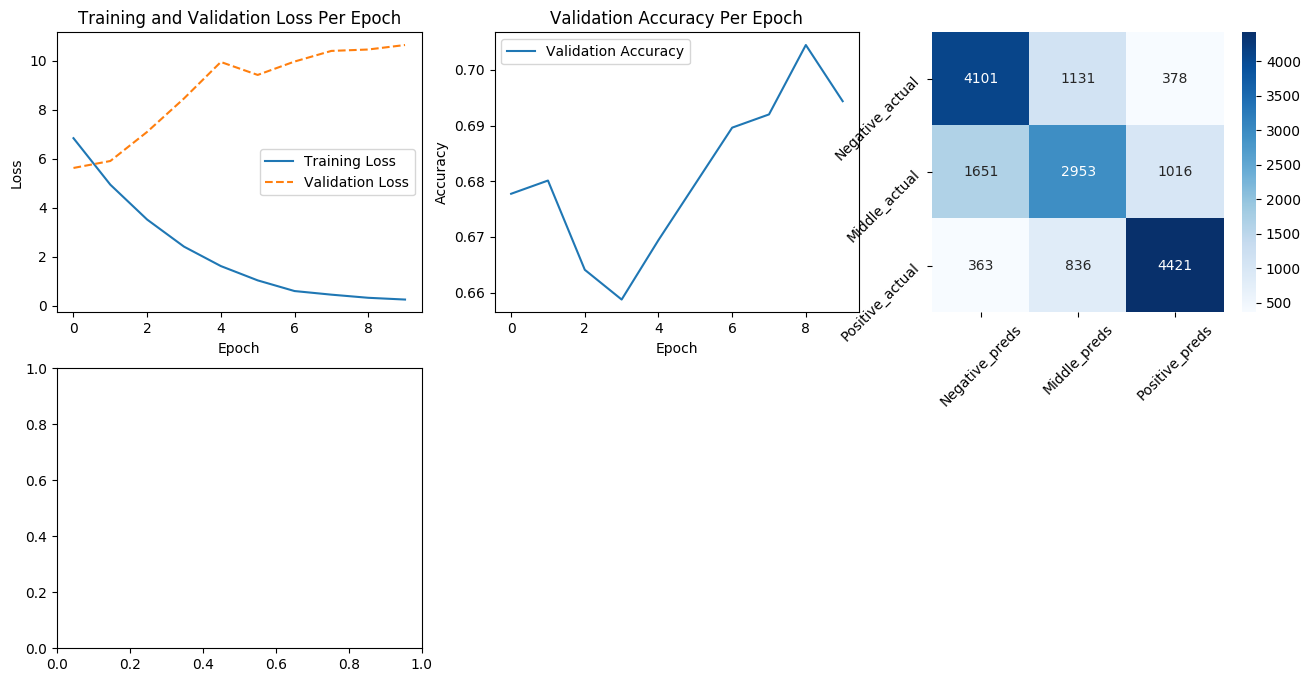

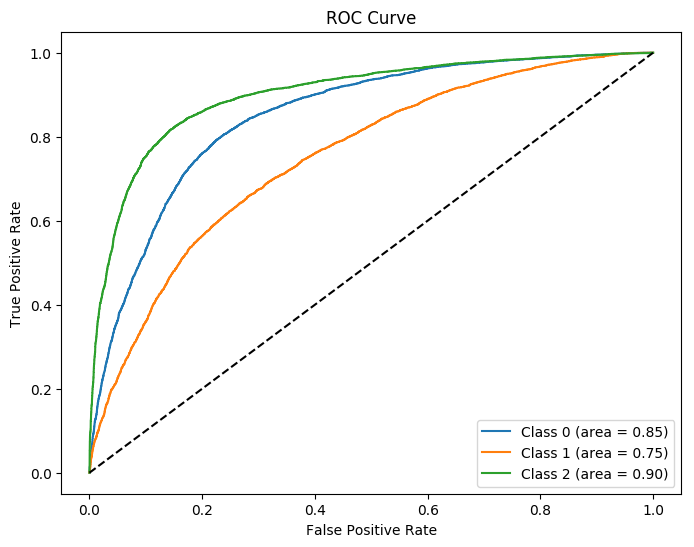

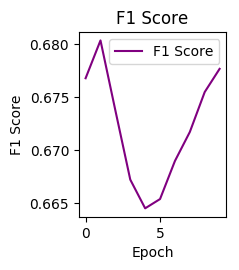

In [58]:
train_model('ernie-3.0-mini-zh',10,2e-5,8,2)

[2024-03-29 18:52:33,497] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-medium-zh'.
[2024-03-29 18:52:33,500] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-3.0-medium-zh/ernie_3.0_medium_zh.pdparams
evaluate valid_loss 1454.706: 100%|██████████| 211/211 [00:03<00:00, 62.27it/s]


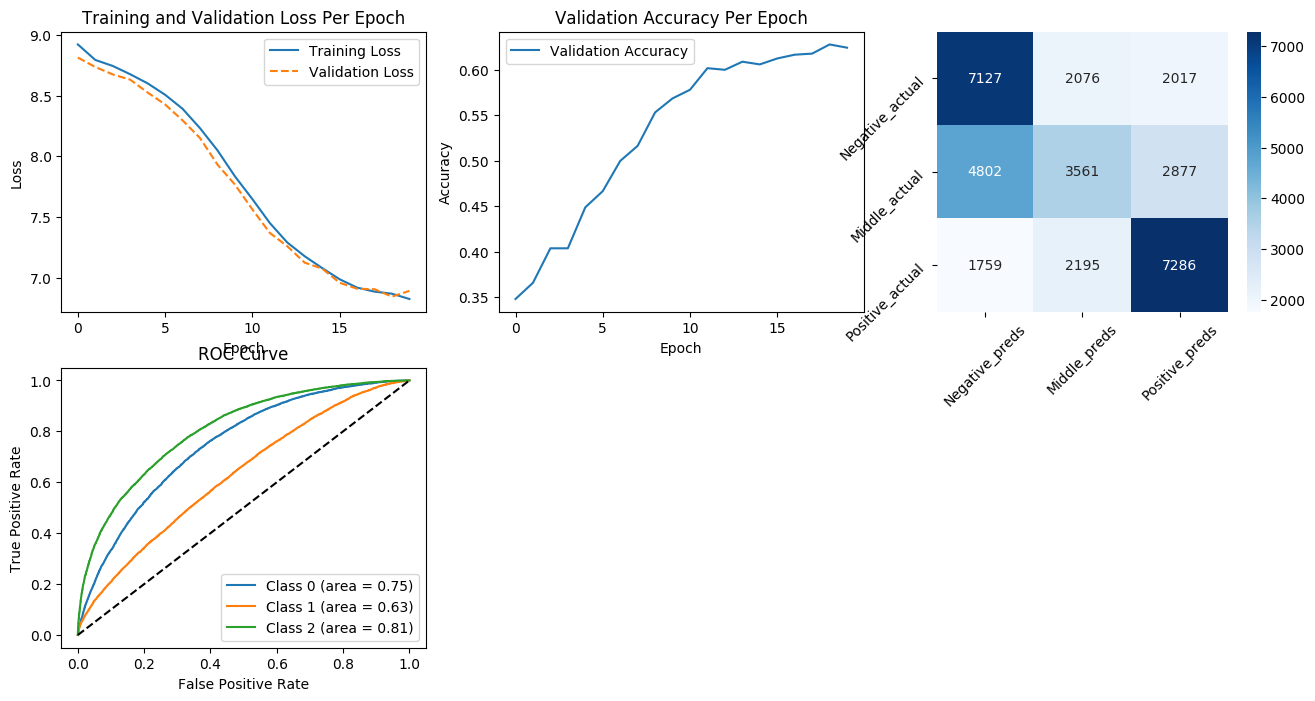

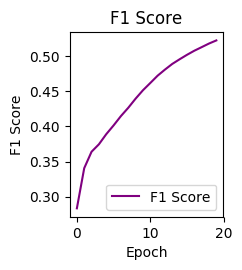

In [70]:
train_model_SGD('ernie-3.0-medium-zh',20,1e-5,16,4)


epoch  20 stage loss 0.06398:  54%|█████▎    | 452/843 [00:15<00:13, 29.05it/s]


epoch  20 stage loss 0.07445:  54%|█████▍    | 454/843 [00:15<00:13, 29.05it/s]


epoch  20 stage loss 0.07445:  54%|█████▍    | 455/843 [00:15<00:12, 30.05it/s]


epoch  20 stage loss 0.01076:  54%|█████▍    | 456/843 [00:15<00:12, 30.05it/s]


epoch  20 stage loss 0.01353:  54%|█████▍    | 458/843 [00:16<00:12, 30.05it/s]


epoch  20 stage loss 0.01353:  54%|█████▍    | 459/843 [00:16<00:12, 30.79it/s]


epoch  20 stage loss 0.25476:  55%|█████▍    | 460/843 [00:16<00:12, 30.79it/s]


epoch  20 stage loss 0.04577:  55%|█████▍    | 462/843 [00:16<00:12, 30.79it/s]


epoch  20 stage loss 0.04577:  55%|█████▍    | 463/843 [00:16<00:12, 31.60it/s]


epoch  20 stage loss 0.04637:  55%|█████▌    | 464/843 [00:16<00:11, 31.60it/s]


epoch  20 stage loss 0.01499:  55%|█████▌    | 466/843 [00:16<00:11, 31.60it/s]


epoch  20 stage loss 0.01499:  55%|█████▌    | 467/843 [00:16<00:11, 32.31it/s]


epoch  20 stage

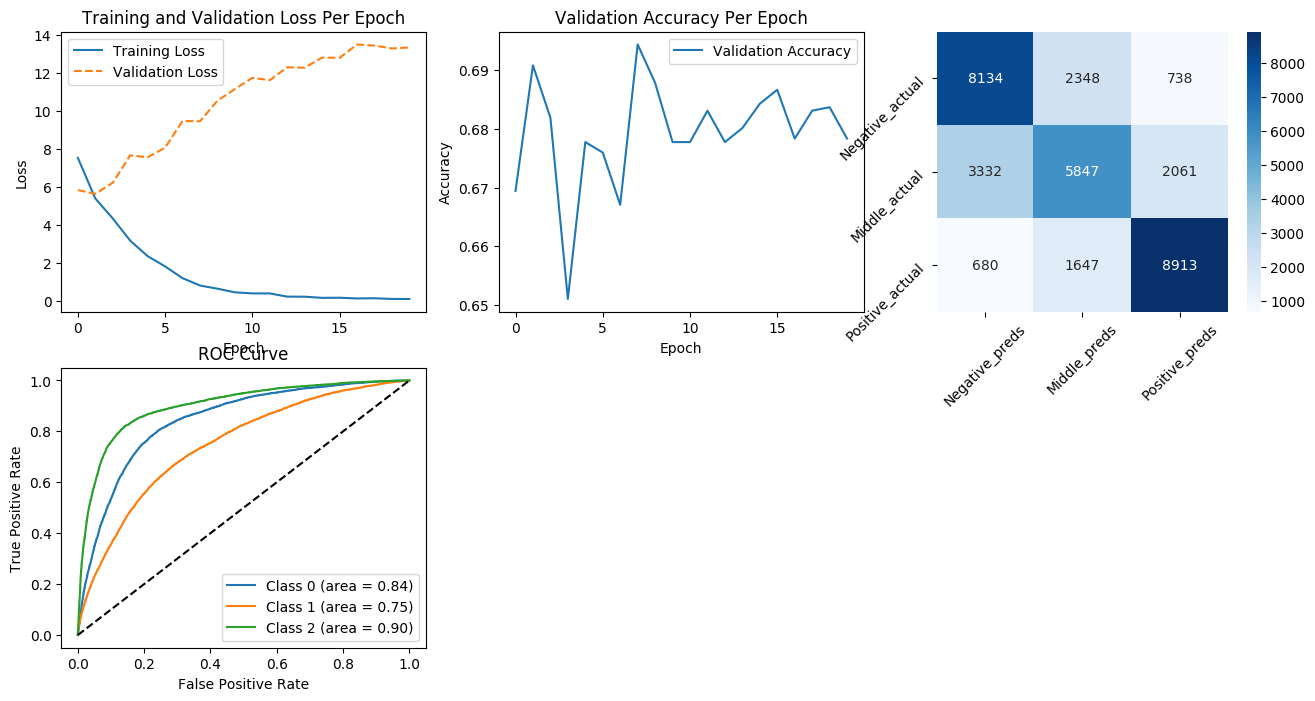

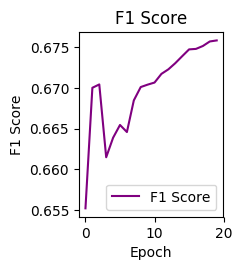

In [91]:
train_model_adam('ernie-3.0-medium-zh',20,1e-5,128,2)

In [ ]:
train_model_adam('ernie-3.0-nano-zh',10,1e-5,128,2)

epoch  10 stage loss 9.06213:  12%|█▏        | 102/843 [00:02<00:20, 36.73it/s]


epoch  10 stage loss 6.74422:  12%|█▏        | 102/843 [00:02<00:20, 36.73it/s]


epoch  10 stage loss 6.48494:  12%|█▏        | 104/843 [00:02<00:20, 36.73it/s]


epoch  10 stage loss 8.03065:  13%|█▎        | 106/843 [00:02<00:20, 36.73it/s]


epoch  10 stage loss 8.03065:  13%|█▎        | 107/843 [00:02<00:19, 38.42it/s]


epoch  10 stage loss 7.08818:  13%|█▎        | 108/843 [00:02<00:19, 38.42it/s]


epoch  10 stage loss 7.72581:  13%|█▎        | 110/843 [00:02<00:19, 38.42it/s]


epoch  10 stage loss 7.72581:  13%|█▎        | 112/843 [00:02<00:17, 40.75it/s]


epoch  10 stage loss 6.35259:  13%|█▎        | 112/843 [00:02<00:17, 40.75it/s]


epoch  10 stage loss 11.43706:  14%|█▎        | 114/843 [00:02<00:17, 40.75it/s]


epoch  10 stage loss 10.15563:  14%|█▍        | 116/843 [00:02<00:17, 40.75it/s]


epoch  10 stage loss 10.15563:  14%|█▍        | 117/843 [00:02<00:17, 41.58it/s]


epoch  10 sta

[2024-03-31 18:35:08,609] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-medium-zh'.
[2024-03-31 18:35:08,613] [    INFO] - Downloading https://bj.bcebos.com/paddlenlp/models/transformers/ernie_3.0/ernie_3.0_medium_zh.pdparams and saved to /home/aistudio/.paddlenlp/models/ernie-3.0-medium-zh
[2024-03-31 18:35:08,616] [    INFO] - Downloading ernie_3.0_medium_zh.pdparams from https://bj.bcebos.com/paddlenlp/models/transformers/ernie_3.0/ernie_3.0_medium_zh.pdparams
100%|██████████| 313M/313M [00:04<00:00, 67.3MB/s] 
evaluate valid_loss 1487.654: 100%|██████████| 160/160 [00:04<00:00, 38.93it/s]


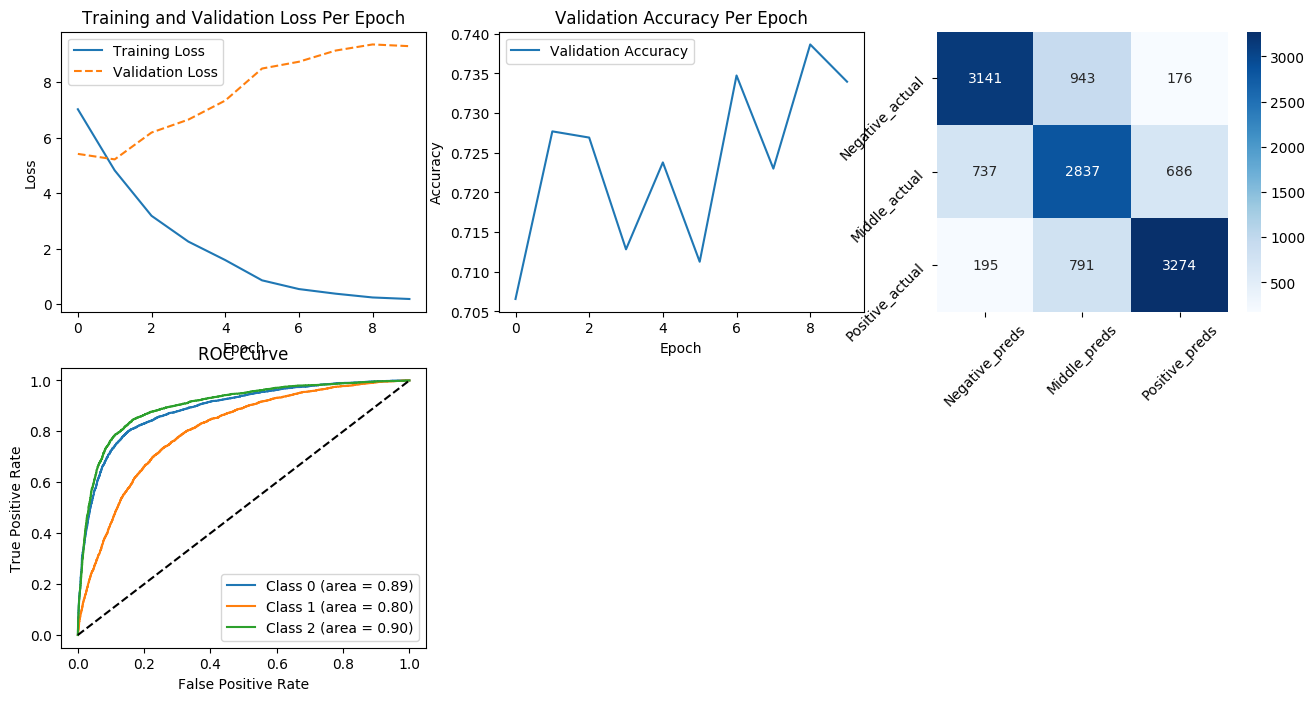

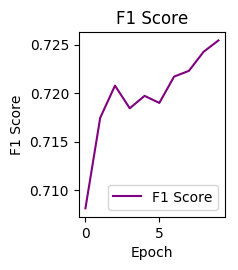

In [33]:
train_model_adam('ernie-3.0-medium-zh',10,2e-5,16,2)

[2024-03-31 18:42:28,753] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-nano-zh'.
[2024-03-31 18:42:28,758] [    INFO] - Downloading https://bj.bcebos.com/paddlenlp/models/transformers/ernie_3.0/ernie_3.0_nano_zh.pdparams and saved to /home/aistudio/.paddlenlp/models/ernie-3.0-nano-zh
[2024-03-31 18:42:28,761] [    INFO] - Downloading ernie_3.0_nano_zh.pdparams from https://bj.bcebos.com/paddlenlp/models/transformers/ernie_3.0/ernie_3.0_nano_zh.pdparams
100%|██████████| 72.4M/72.4M [00:01<00:00, 68.1MB/s]
evaluate valid_loss 1286.509: 100%|██████████| 160/160 [00:03<00:00, 45.83it/s]


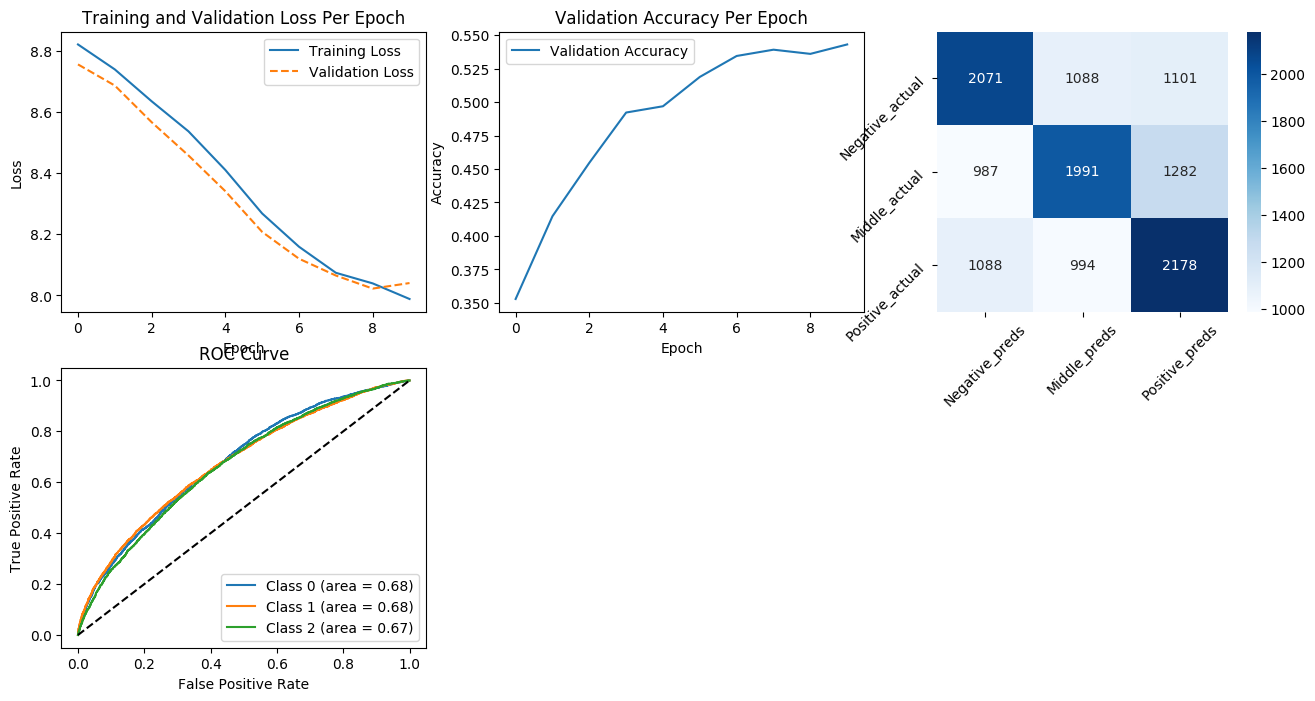

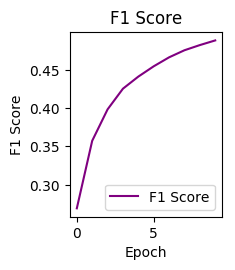

In [34]:
train_model_adam('ernie-3.0-nano-zh',10,1e-6,128,2) #不过拟合，但是学习太慢，效果太差

[2024-03-31 18:47:46,311] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-nano-zh'.
[2024-03-31 18:47:46,315] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-3.0-nano-zh/ernie_3.0_nano_zh.pdparams
evaluate valid_loss 985.817: 100%|██████████| 160/160 [00:03<00:00, 48.66it/s]


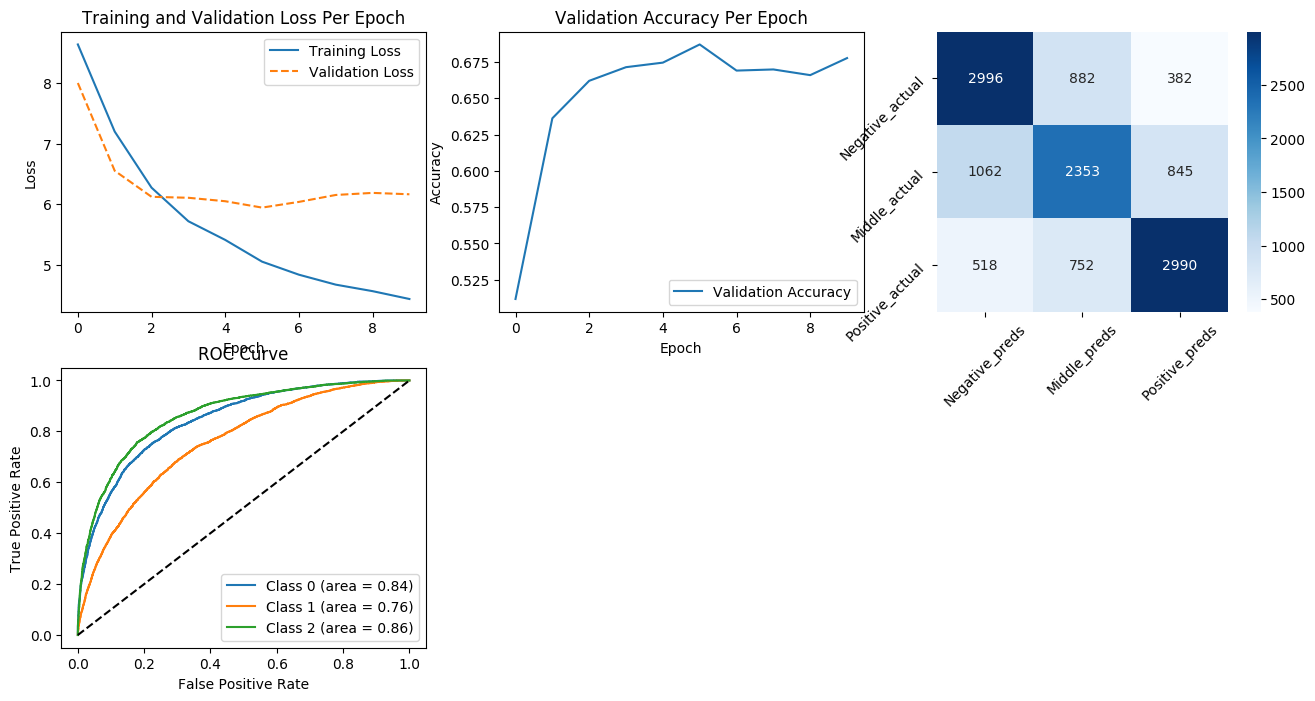

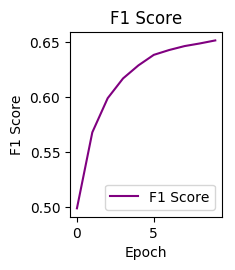

In [35]:
train_model_adam('ernie-3.0-nano-zh',10,1e-5,128,2)

[2024-03-31 18:58:47,193] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-medium-zh'.
[2024-03-31 18:58:47,198] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-3.0-medium-zh/ernie_3.0_medium_zh.pdparams
evaluate valid_loss 1653.910: 100%|██████████| 160/160 [00:03<00:00, 41.84it/s]


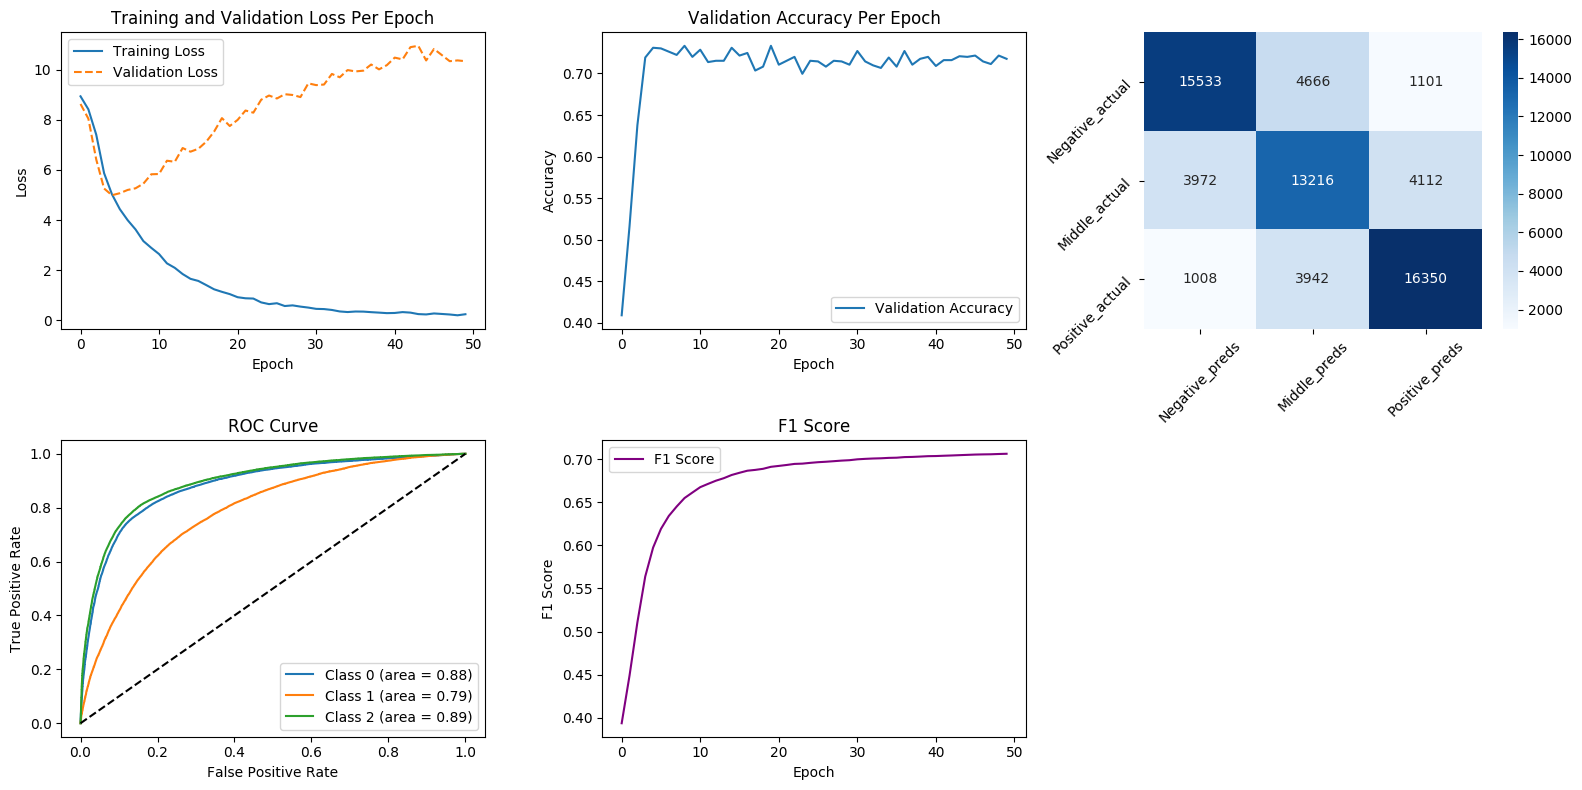

In [38]:
train_model_adam('ernie-3.0-medium-zh',50,2e-6,128,2)

[2024-04-03 00:17:17,029] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-medium-zh'.
[2024-04-03 00:17:17,034] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-3.0-medium-zh/ernie_3.0_medium_zh.pdparams
evaluate valid_loss 1306.011: 100%|██████████| 365/365 [00:08<00:00, 44.56it/s]


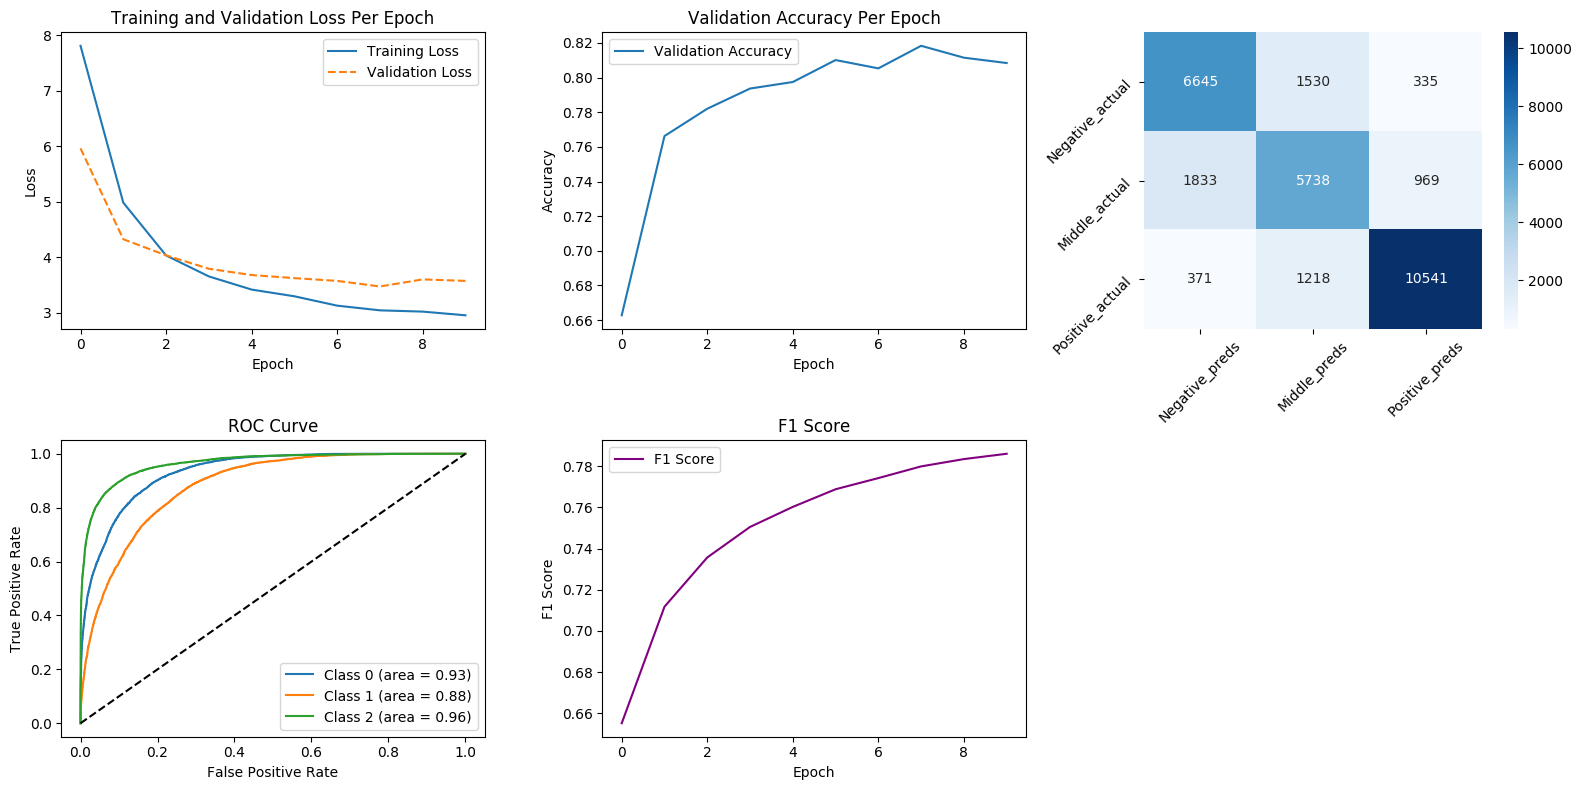

In [19]:
train_model_adam('ernie-3.0-medium-zh',10,1e-6,128,2)

In [29]:
train_model_adam_constwarm('ernie-3.0-medium-zh',100,1e-7,256,2)

[2024-04-03 00:52:28,786] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-medium-zh'.
[2024-04-03 00:52:28,790] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-3.0-medium-zh/ernie_3.0_medium_zh.pdparams




epoch  1:   0%|          | 0/1459 [00:00<?, ?it/s]



epoch  1 stage loss 9.04187:   0%|          | 0/1459 [00:00<?, ?it/s]



epoch  1 stage loss 9.04187:   0%|          | 1/1459 [00:00<04:18,  5.63it/s]



epoch  1 stage loss 9.04187:   0%|          | 3/1459 [00:00<02:17, 10.57it/s]



epoch  1 stage loss 36.01509:   0%|          | 4/1459 [00:00<02:17, 10.57it/s]



epoch  1 stage loss 36.01509:   0%|          | 7/1459 [00:00<01:26, 16.84it/s]



epoch  1 stage loss 35.78225:   1%|          | 8/1459 [00:00<01:26, 16.84it/s]



epoch  1 stage loss 35.78225:   1%|          | 10/1459 [00:00<01:21, 17.71it/s]



epoch  1 stage loss 35.31769:   1%|          | 12/1459 [00:00<01:21, 17.71it/s]


KeyboardInterrupt: 

[2024-04-03 09:25:20,594] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-medium-zh'.
[2024-04-03 09:25:20,598] [    INFO] - Downloading https://bj.bcebos.com/paddlenlp/models/transformers/ernie_3.0/ernie_3.0_medium_zh.pdparams and saved to /home/aistudio/.paddlenlp/models/ernie-3.0-medium-zh
[2024-04-03 09:25:20,600] [    INFO] - Downloading ernie_3.0_medium_zh.pdparams from https://bj.bcebos.com/paddlenlp/models/transformers/ernie_3.0/ernie_3.0_medium_zh.pdparams
100%|██████████| 313M/313M [00:06<00:00, 49.0MB/s] 
evaluate valid_loss 752.051: 100%|██████████| 365/365 [00:05<00:00, 67.21it/s]


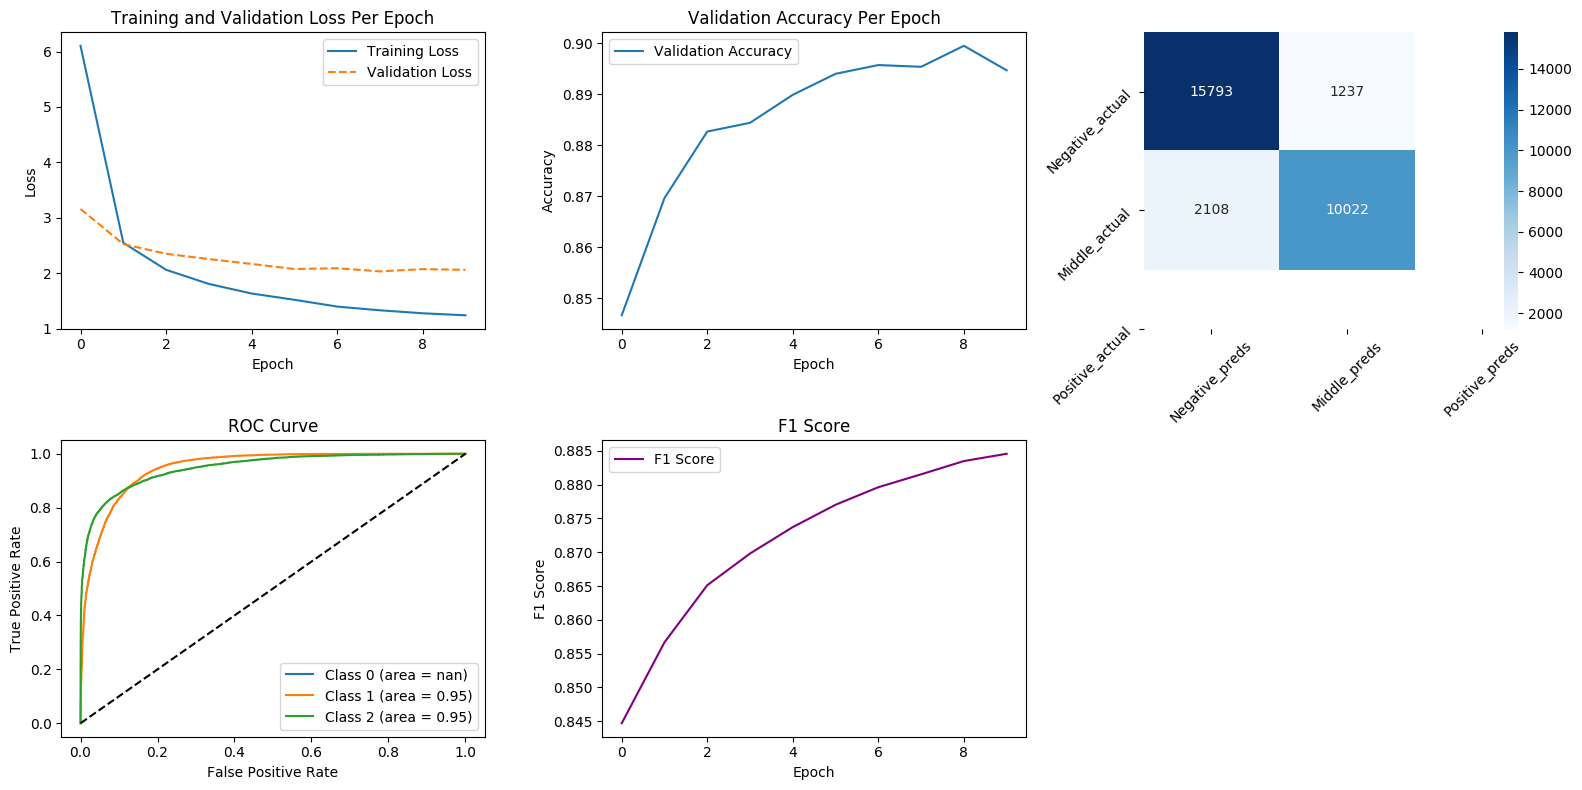

In [16]:
train_model_adam('ernie-3.0-medium-zh',10,1e-6,128,2)

[2024-04-03 09:37:58,958] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-medium-zh'.
[2024-04-03 09:37:58,962] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-3.0-medium-zh/ernie_3.0_medium_zh.pdparams
evaluate valid_loss 1265.426: 100%|██████████| 320/320 [00:05<00:00, 63.57it/s]


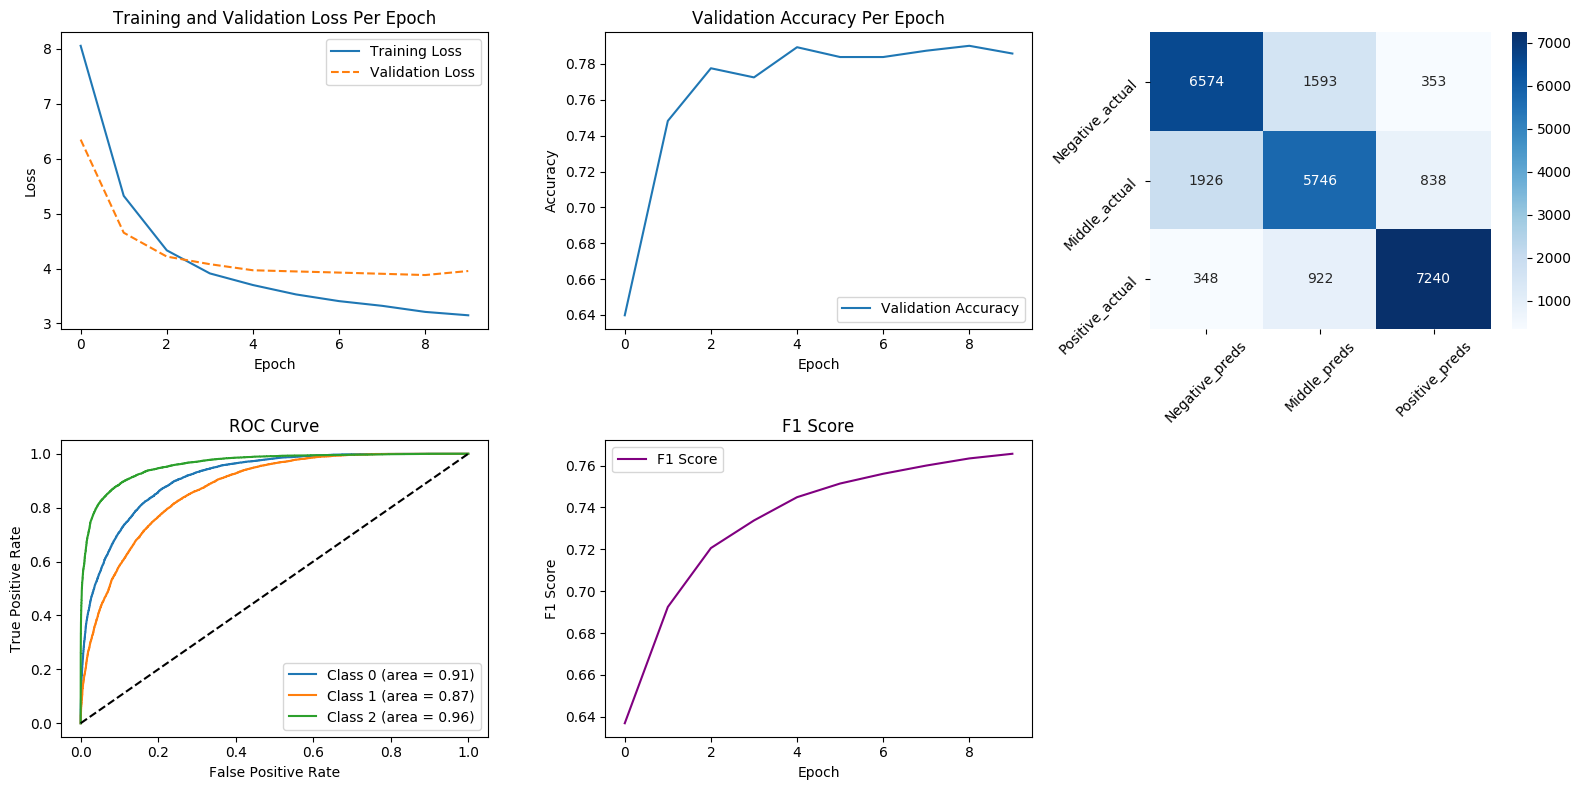

In [22]:
train_model_adam('ernie-3.0-medium-zh',10,1e-6,128,2)

epoch  9 total loss 2339.15105: 100%|██████████| 852/852 [00:23<00:00, 36.20it/s]

evaluate valid_loss 742.758: 100%|██████████| 213/213 [00:02<00:00, 77.10it/s]
[2024-04-22 21:37:05,346] [    INFO] - tokenizer config file saved in model/saved_parameters/tokenizer_config.json
[2024-04-22 21:37:05,350] [    INFO] - Special tokens file saved in model/saved_parameters/special_tokens_map.json

epoch  10 total loss 2316.40940: 100%|██████████| 852/852 [00:24<00:00, 34.65it/s]

evaluate valid_loss 732.467: 100%|██████████| 213/213 [00:02<00:00, 75.24it/s]
[2024-04-22 21:37:40,388] [    INFO] - tokenizer config file saved in model/saved_parameters/tokenizer_config.json
[2024-04-22 21:37:40,391] [    INFO] - Special tokens file saved in model/saved_parameters/special_tokens_map.json


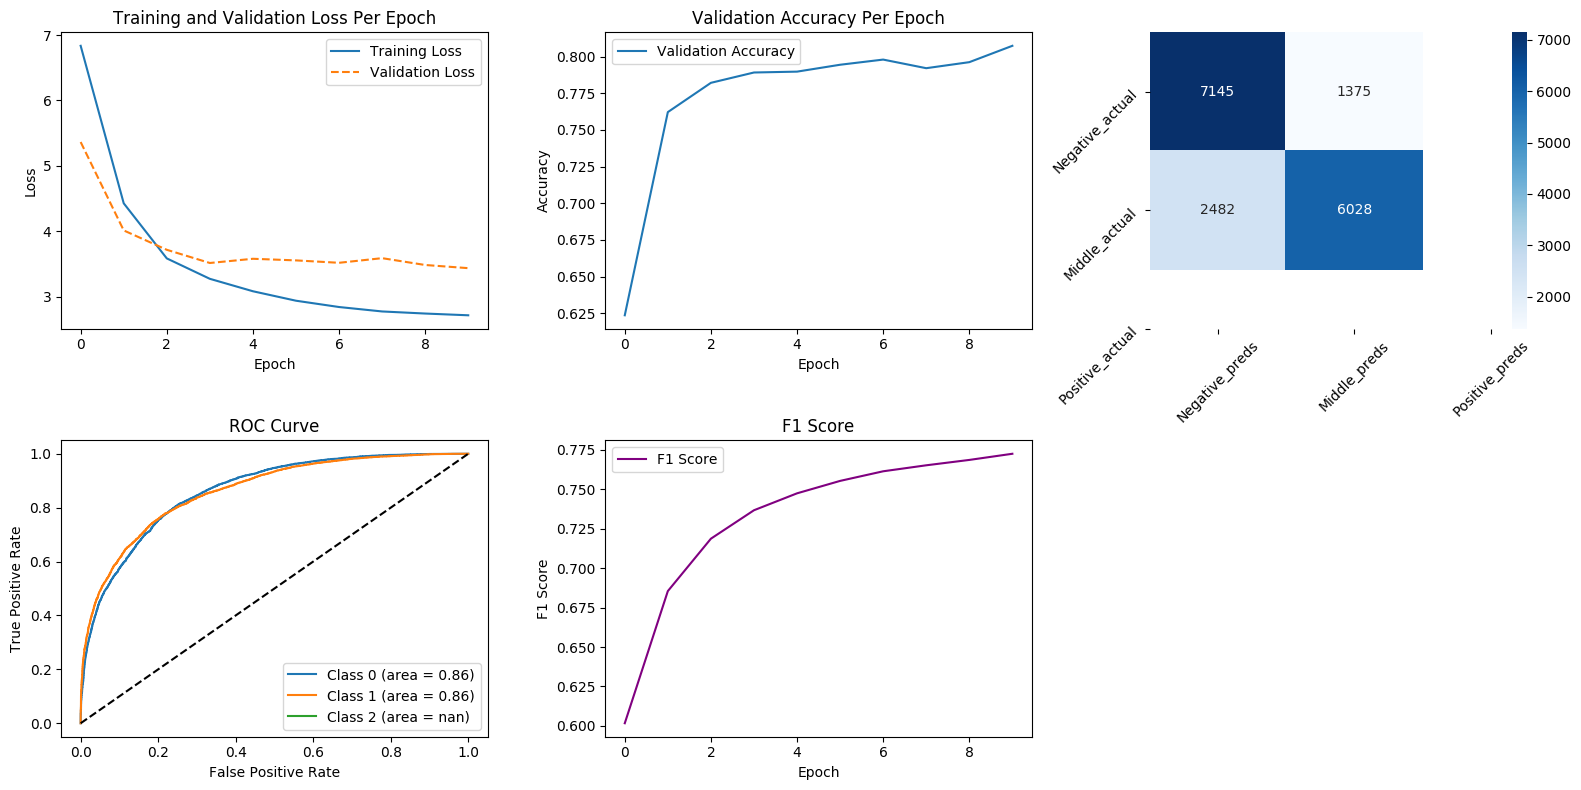

In [32]:
train_model_adam_2('ernie-3.0-medium-zh',10,1e-6,128,2)

[2024-04-03 10:25:30,670] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-mini-zh'.
[2024-04-03 10:25:30,674] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-3.0-mini-zh/ernie_3.0_mini_zh.pdparams
evaluate valid_loss 1403.241: 100%|██████████| 320/320 [00:04<00:00, 65.65it/s]


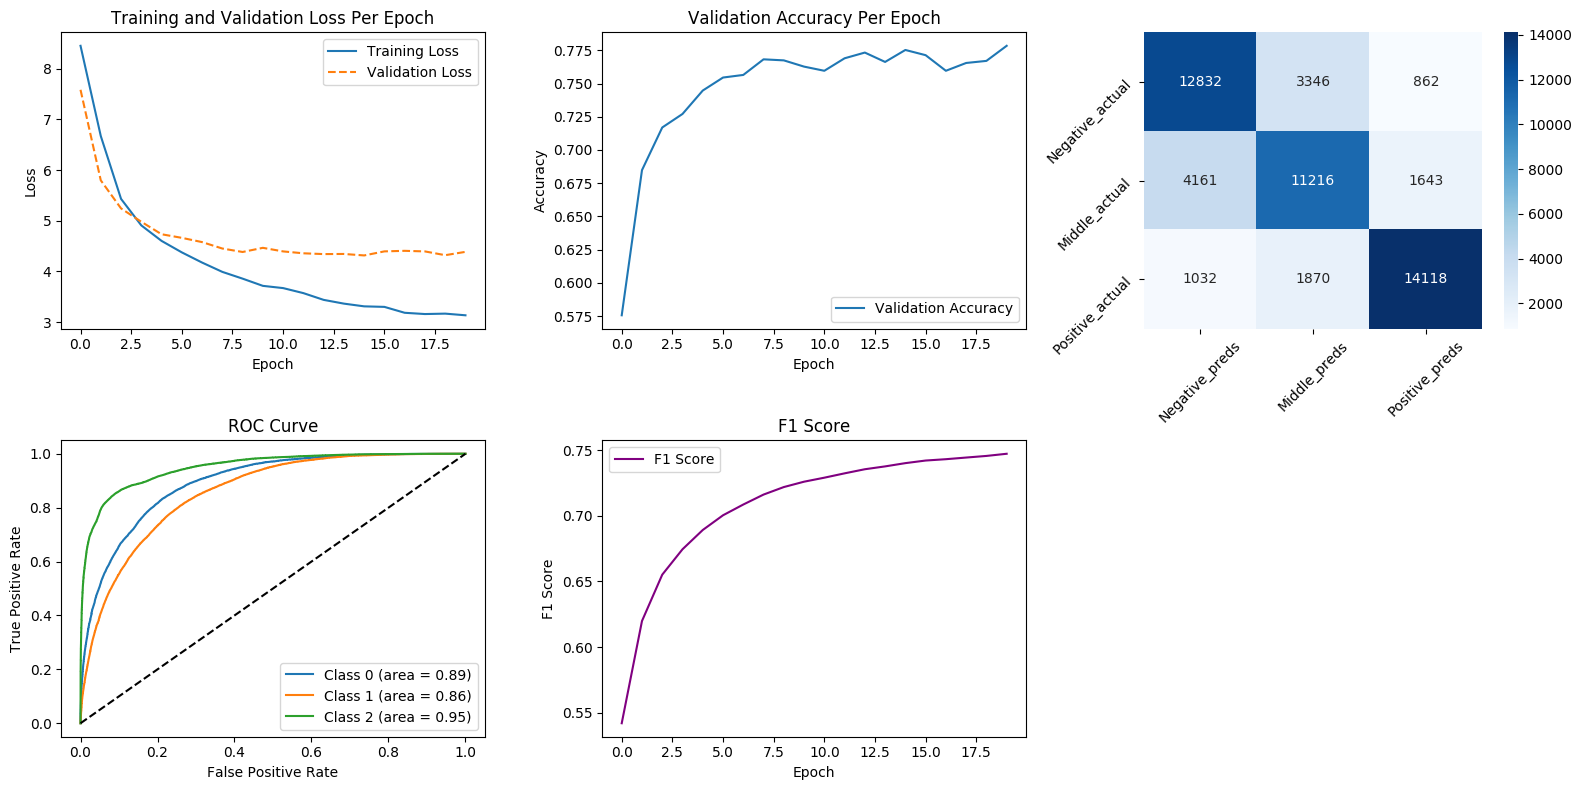

In [60]:
train_model_adam('ernie-3.0-mini-zh',20,2e-6,128,2)

In [23]:
train_model_adam_3('ernie-3.0-medium-zh',10,1e-6,128,2)

[2024-04-07 20:05:02,040] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-medium-zh'.
[2024-04-07 20:05:02,043] [    INFO] - Downloading https://bj.bcebos.com/paddlenlp/models/transformers/ernie_3.0/ernie_3.0_medium_zh.pdparams and saved to /home/aistudio/.paddlenlp/models/ernie-3.0-medium-zh
[2024-04-07 20:05:02,046] [    INFO] - Downloading ernie_3.0_medium_zh.pdparams from https://bj.bcebos.com/paddlenlp/models/transformers/ernie_3.0/ernie_3.0_medium_zh.pdparams
100%|██████████| 313M/313M [00:07<00:00, 46.1MB/s] 
epoch  1:   0%|          | 0/1458 [00:00<?, ?it/s]

Error: /paddle/paddle/phi/kernels/gpu/cross_entropy_kernel.cu:1008 Assertion `false` failed. The value of label expected >= 0 and < 2, or == -100, but got 2. Please check label value.
Error: /paddle/paddle/phi/kernels/gpu/cross_entropy_kernel.cu:1008 Assertion `false` failed. The value of label expected >= 0 and < 2, or == -100, but got 2. Please check label value.


OSError: (External) CUDA error(719), unspecified launch failure. 
  [Hint: Please search for the error code(719) on website (https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html#group__CUDART__TYPES_1g3f51e3575c2178246db0a94a430e0038) to get Nvidia's official solution and advice about CUDA Error.] (at /paddle/paddle/phi/backends/gpu/cuda/cuda_info.cc:259)


In [ ]:
train_model_adam('ernie-3.0-mini-zh',20,2e-6,128,2)

In [11]:
def load_dataset1(data_path):
    # 定义数据读取方式
    def read(data_path):
        with open(data_path, 'r', encoding='utf-8') as f:
            for line in f:
                yield {'text': line.strip()}

    # 使用MapDataset加载数据
    return load_dataset(read, data_path=data_path, lazy=False)

test = pd.read_csv("/home/aistudio/data/zssh000016.csv")
test  = test.loc[:,'标题']
test.to_csv("test.txt",sep='\t',index=False,header=False)

In [6]:
def load_dataset1(data_path):
    # 定义数据读取方式
    def read(data_path):
        with open(data_path, 'r', encoding='utf-8') as f:
            for line in f:
                yield {'text': line.strip()}

    # 使用MapDataset加载数据
    return load_dataset(read, data_path=data_path, lazy=False)

test_all = pd.read_csv("/home/aistudio/work/data_all.csv")
test_all  = test_all.loc[:,'标题']
test_all.to_csv("test_all.txt",sep='\t',index=False,header=False)

In [37]:
def train_model_adam_test(checkpoint, num_epoch, learning_rate, batch_size, accumulation_steps):

    # **************************初始化训练对象***************************
    # 加载数据集
    train_set, valid_set = load_data()
    # 初始化模型
    estimator = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                               num_classes=3)

    # 动态学习率
    scheduler = LinearDecayWithWarmup(learning_rate=learning_rate,
                                        total_steps=len(train_set)*num_epoch,
                                        warmup=0.1
                                        )
    # scheduler = ConstScheduleWithWarmup(learning_rate=learning_rate,
    #                                 total_steps=len(train_set)*num_epoch,
    #                                 warmup=0.1
    #                                 )
    # 优化方法
    optimizer = AdamW(parameters=estimator.parameters(),
                      learning_rate=scheduler,weight_decay=0.1)
    # 损失函数
    criterion = CrossEntropyLoss(use_softmax=True)
    # 评估方法
    metric = Accuracy()
    # 初始化存储数组
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    f1_scores = []
    auc_scores = []
    all_preds = []
    all_labels = []
    all_probs = []
    
    custom_dropout = CustomDropoutLayer(dropout_prob=0.5)
    # 训练逻辑
    for epoch_idx in range(num_epoch):

        # **************************训练集训练*************************
        optimizer.clear_grad()
        progress = tqdm(range(len(train_set)),
                        desc='epoch %2d' % (epoch_idx + 1))
        total_loss = 0.0  # 轮次损失
        stage_loss = 0.0  # 阶段损失
        for iter_idx, (batch_inputs, batch_labels) in enumerate(train_set):
            batch_inputs = custom_dropout(batch_inputs)
            # 模型计算
            outputs = estimator(**batch_inputs)
            # 损失计算
            loss = criterion(outputs, batch_labels)
            # 训练信息
            total_loss += loss.item() * len(batch_labels)
            stage_loss += loss.item() * len(batch_labels)
            # 梯度计算
            (loss / accumulation_steps).backward()

            # 参数更新
            if iter_idx % accumulation_steps == 0:
                optimizer.step()
                optimizer.clear_grad()
                progress.set_description('epoch % 2d stage loss %.5f'
                                         % (epoch_idx + 1, stage_loss))
                stage_loss = 0.0
            # 学习率更新
            scheduler.step()
            # 进度条更新
            progress.update()

        # 设置轮次损失
        progress.set_description('epoch % 2d total loss %.5f'
                                 % (epoch_idx + 1, total_loss))
        average_loss = total_loss / len(train_set)
        train_losses.append(average_loss)
        # 关闭进度条
        progress.close()

        # **************************验证集评估*************************
        with paddle.no_grad():
            total_valid_loss = 0
            progress = tqdm(range(len(valid_set)), desc='evaluate')
            metric.reset()

            for iter_idx, (batch_inputs, batch_labels) in enumerate(valid_set):
                # 模型计算
                outputs = estimator(**batch_inputs)
                loss = criterion(outputs,batch_labels)
                total_valid_loss += loss.item()* len(batch_labels)
                # 计算概率
                probas = F.softmax(outputs)
                #获取预测标签
                preds = paddle.argmax(probas,axis=1)
                #保存预测和真实标签
                all_preds.extend(preds.numpy())
                all_labels.extend(batch_labels.numpy())
                all_probs.extend(probas.numpy())
                # 标签预测
                correct = metric.compute(probas, batch_labels)
                metric.update(correct)
                
                # 进度条更新
                progress.update()

            f1 = f1_score(all_labels,all_preds,average='weighted')
            f1_scores.append(f1)

            # 设置轮次损失
            acc = metric.accumulate()
            valid_accuracies.append(acc)
            average_valid_loss = total_valid_loss / len(valid_set)
            valid_losses.append(average_valid_loss)
            progress.set_description('evaluate acc %.3f' % acc)
            
            progress.set_description('evaluate valid_loss %.3f' % total_valid_loss)

            # 关闭进度条
            progress.close()

            #模型保存
            model_params = {
            'checkpoint': checkpoint,
            'num_epoch': num_epoch,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'accumulation_steps': accumulation_steps,
            'train_loss': train_losses,
            'valid_loss': valid_losses,
            'valid_accuracy': valid_accuracies,
            'f1_score': f1_scores,
            }
            model_save_dir = 'model1/senti-%d-%.5f' % (epoch_idx + 1, acc)
            paddle.save(model_params,f'{model_save_dir}_model/senti_{checkpoint}_lr{learning_rate}_bs{batch_size}_epochs{num_epoch}.pdparams')
            if not os.path.exists(model_save_dir):
                os.makedirs(model_save_dir)
            estimator.save_pretrained(model_save_dir)
            tokenizer.save_pretrained(model_save_dir)
            paddle.save(optimizer.state_dict(), os.path.join(model_save_dir, 'optimizer.optparams'))
            paddle.save(scheduler.state_dict(), os.path.join(model_save_dir, 'scheduler.optparams'))

    # 在函数的最后，绘制损失和准确率图像
    plt.figure(figsize=(16, 8))

    # 绘制训练损失图像
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses,label='Validation Loss',linestyle='--')
    plt.title('Training and Validation Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制验证准确率图像
    plt.subplot(2, 3, 2)
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    #绘制混淆矩阵
    plt.subplot(2,3,3)
    cm =confusion_matrix(all_labels,all_preds)
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=['Negative_preds', 'Middle_preds', 'Positive_preds'], yticklabels=['Negative_actual', 'Middle_actual', 'Positive_actual'])
    plt.xticks(rotation=45) 
    plt.yticks(rotation=45)
    
    #绘制ROC曲线
    plt.subplot(2,3,4)
    all_probs = np.array(all_probs)
    plot_roc_curve(all_labels,all_probs)


    #绘制F1分数
    plt.subplot(2,3,5)
    plt.plot(f1_scores,label='F1 Score',color='purple')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


[2024-04-22 22:28:20,356] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-mini-zh'.
[2024-04-22 22:28:20,360] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-3.0-mini-zh/ernie_3.0_mini_zh.pdparams
evaluate valid_loss 2724.156: 100%|██████████| 320/320 [00:04<00:00, 78.59it/s]
[2024-04-22 22:28:59,664] [    INFO] - tokenizer config file saved in model/saved_parameters/tokenizer_config.json
[2024-04-22 22:28:59,668] [    INFO] - Special tokens file saved in model/saved_parameters/special_tokens_map.json
evaluate valid_loss 2141.483: 100%|██████████| 320/320 [00:04<00:00, 78.19it/s]
[2024-04-22 22:29:40,486] [    INFO] - tokenizer config file saved in model/saved_parameters/tokenizer_config.json
[2024-04-22 22:29:40,490] [    INFO] - Special tokens file saved in model/saved_parameters/special_tokens_map.json
evaluate valid_loss 1849.393: 100%|██████████| 320/320 [00:04<00:00, 76.77it/s]
[2024-04

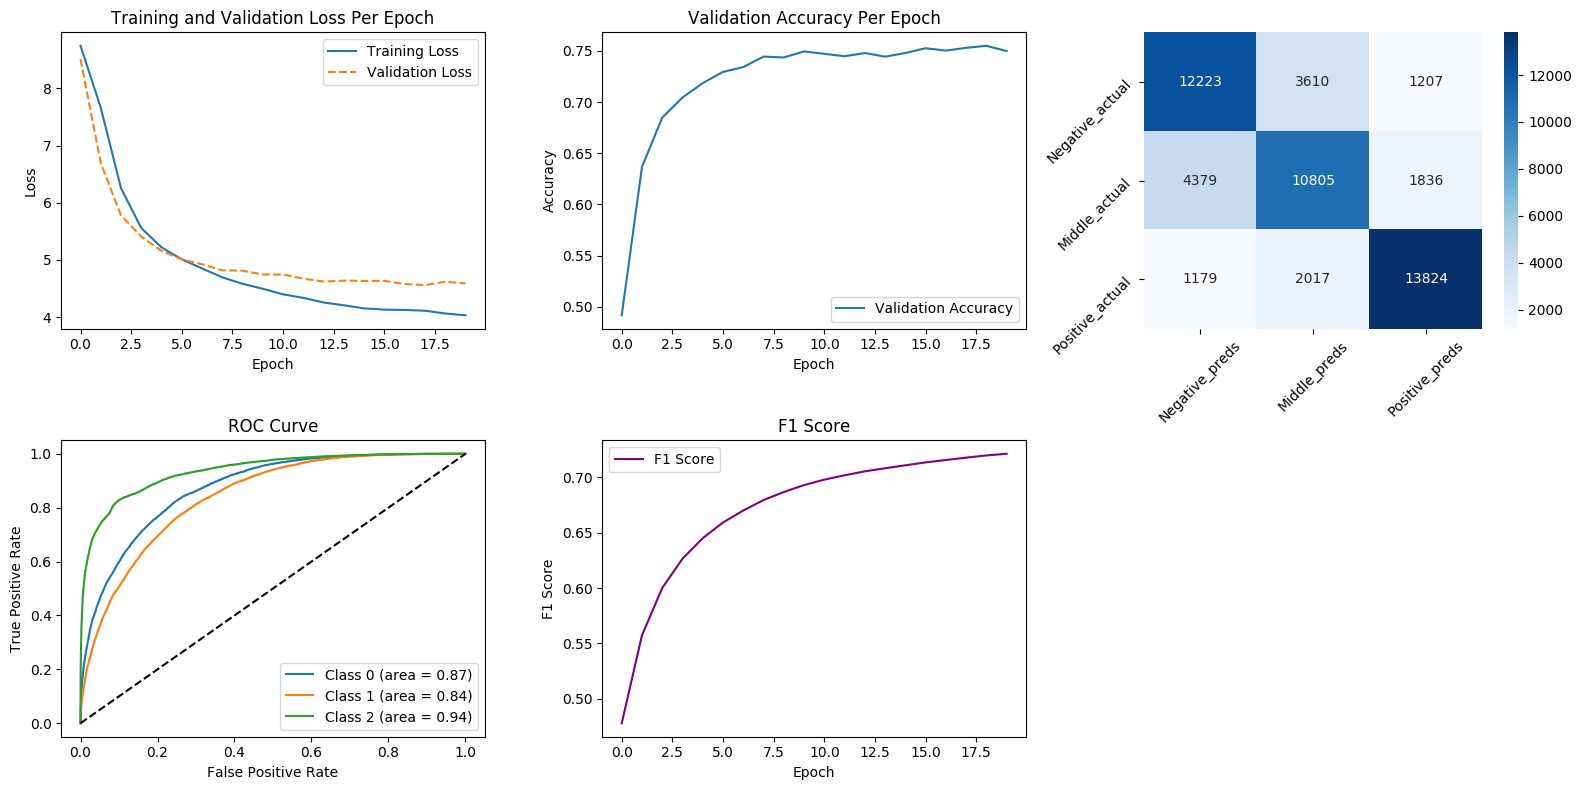

In [17]:
train_model_adam_test('ernie-3.0-mini-zh',20,1e-6,64,2)


epoch  10 stage loss 0.33207:  52%|█████▏    | 669/1277 [00:18<00:16, 37.15it/s]

epoch  10 stage loss 2.18464:  52%|█████▏    | 670/1277 [00:18<00:16, 37.15it/s]

epoch  10 stage loss 2.01868:  53%|█████▎    | 672/1277 [00:18<00:16, 37.15it/s]

epoch  10 stage loss 2.01868:  53%|█████▎    | 673/1277 [00:18<00:16, 36.92it/s]

epoch  10 stage loss 1.72391:  53%|█████▎    | 674/1277 [00:18<00:16, 36.92it/s]

epoch  10 stage loss 6.48199:  53%|█████▎    | 676/1277 [00:18<00:16, 36.92it/s]

epoch  10 stage loss 6.48199:  53%|█████▎    | 677/1277 [00:18<00:17, 35.13it/s]

epoch  10 stage loss 5.75759:  53%|█████▎    | 678/1277 [00:18<00:17, 35.13it/s]

epoch  10 stage loss 6.47441:  53%|█████▎    | 680/1277 [00:18<00:16, 35.13it/s]

epoch  10 stage loss 6.47441:  53%|█████▎    | 681/1277 [00:18<00:16, 35.14it/s]

epoch  10 stage loss 5.04708:  53%|█████▎    | 682/1277 [00:18<00:16, 35.14it/s]

epoch  10 stage loss 2.43599:  54%|█████▎    | 684/1277 [00:18<00:16, 35.14it/s]

epoch  10 stage

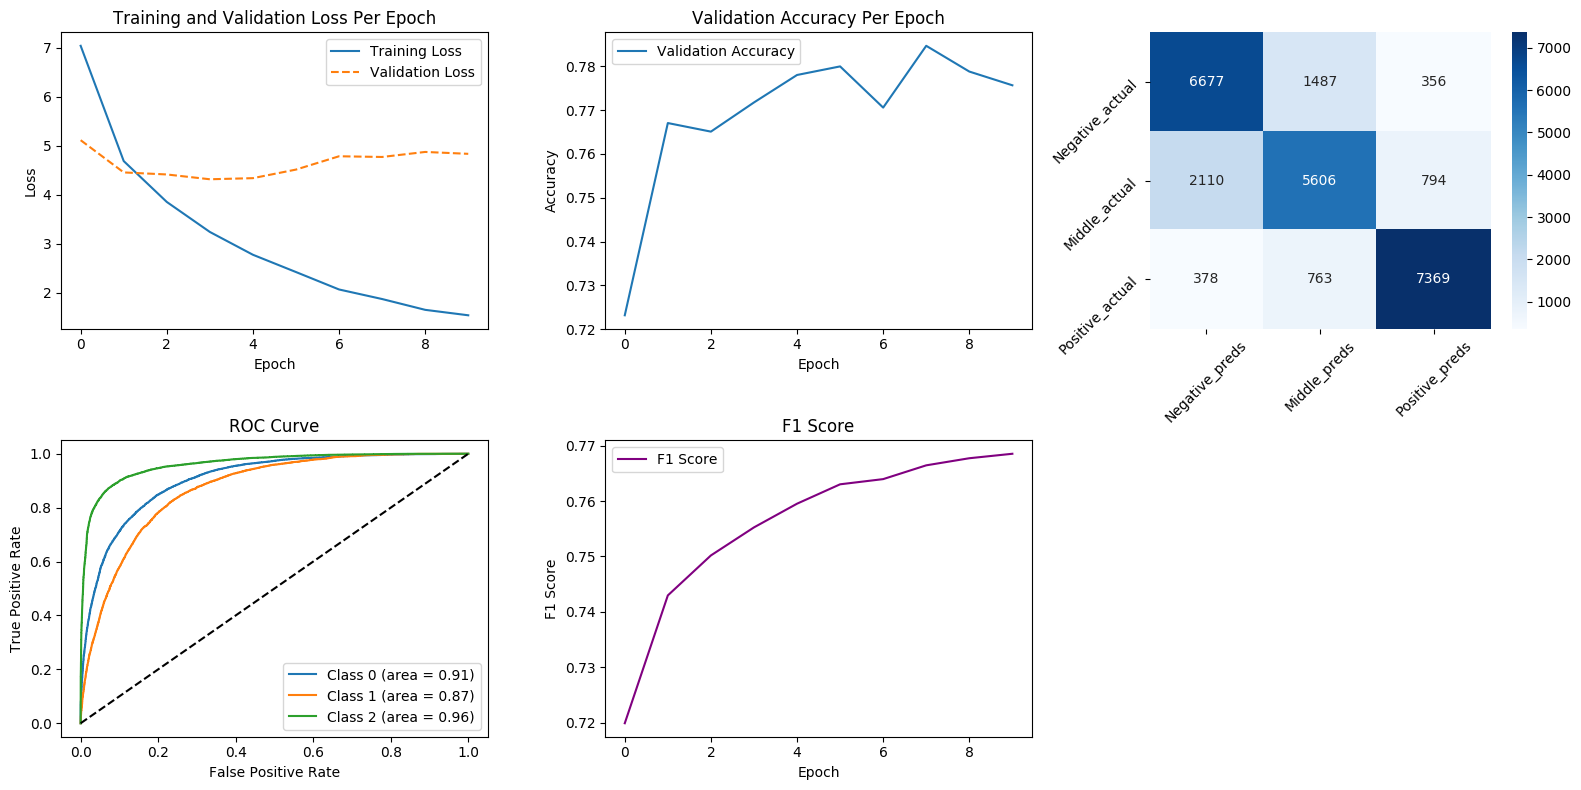

In [39]:
train_model_adam_test('ernie-3.0-mini-zh',10,1e-5,64,2)

In [51]:
def predict_to_csv():
    # 获得模型名字
    epoch_index = 7
    model_name = glob.glob('model1/*')[epoch_index]  # 确保路径正确

    # 读取模型
    tokenizer = ErnieTokenizer.from_pretrained(model_name)
    estimator = ErnieForSequenceClassification.from_pretrained(model_name)
    estimator.eval()


    # 获得测试集
    def load_test(batch_size=16):
        test = load_dataset1(data_path='test.txt')
        def collate_fn(model_inputs):
            return tokenizer(model_inputs['text'],
                                    truncation=True,
                                    max_length=510,
                                    add_special_tokens=True,
                                    return_tensors='pd'), model_inputs['text']
        params = {'batch_size': None, 'collate_fn': collate_fn, 'shuffle': True}
        return DataLoader(test, **params)
    test_set = load_test()
    results = []
    with paddle.no_grad():
        for model_inputs, input_texts in test_set:
            outputs = estimator(**model_inputs)
            probas = F.softmax(outputs, axis=1).numpy()
            # 收集每个文本及其预测的数字标签
            for text, proba in zip(input_texts, probas):
                label_idx = proba.argmax()
                results.append({'文本': text, '情感分类': label_idx})

    # 将结果保存到CSV文件
    df_results = pd.DataFrame(results)
    df_results.to_csv('prediction_results.csv', index=False, encoding='utf_8_sig')

In [8]:
import glob
from paddlenlp.transformers import ErnieTokenizer, ErnieForSequenceClassification
from paddle.io import DataLoader
import pandas as pd
import paddle.nn.functional as F

def collate_fn(batch):
    # 假设batch是由字典组成的列表，每个字典都包含一个'text'键
    texts = [data['text'] for data in batch]  # 提取文本
    model_inputs = tokenizer(texts, truncation=True, max_length=510, add_special_tokens=True, return_tensors='pd')
    return model_inputs, texts  # 返回处理后的输入和原始文本列表

def predict_to_csv():
    model_name = glob.glob('model1/*')[7]  # 根据具体情况调整索引

    tokenizer = ErnieTokenizer.from_pretrained(model_name)
    estimator = ErnieForSequenceClassification.from_pretrained(model_name)
    estimator.eval()

    def load_test(batch_size=16):
        test = load_dataset1(data_path='test_all.txt')  # 确保此函数正确加载数据
        params = {'batch_size': batch_size, 'collate_fn': collate_fn, 'shuffle': True}
        return DataLoader(test, **params)

    test_set = load_test()
    results = []
    with paddle.no_grad():
        for model_inputs, input_texts in test_set:
            outputs = estimator(**model_inputs)
            probas = F.softmax(outputs, axis=1).numpy()
            for text, proba in zip(input_texts, probas):
                label_idx = proba.argmax()
                results.append({'文本': text, '情感分类': label_idx})

    df_results = pd.DataFrame(results)
    df_results.to_csv('prediction_results_all.csv', index=False, encoding='utf_8_sig')

In [8]:
def predict_to_csv_plus():
    model_files = glob.glob('model1/*')
    if len(model_files) > 7:
        model_name = model_files[7]  # 根据具体情况调整索引
    else:
        raise ValueError("Model index out of range.")

    tokenizer = ErnieTokenizer.from_pretrained(model_name)
    estimator = ErnieForSequenceClassification.from_pretrained(model_name)
    estimator.eval()

    class TextDataset(paddle.io.Dataset):
        def __init__(self, file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                self.lines = [line.strip() for line in file if line.strip()]

        def __len__(self):
            return len(self.lines)

        def __getitem__(self, idx):
            return {'text': self.lines[idx]}
    def collate_fn(batch):
        texts = [data['text'] for data in batch]
        model_inputs = tokenizer(texts, truncation=True, max_length=510, add_special_tokens=True, return_tensors='pd', padding=True)
        return model_inputs, texts

    def load_test(batch_size=16):
        test = TextDataset(file_path='test_all.txt')
        return DataLoader(test, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

    test_set = load_test()
    results = []
    with paddle.no_grad():
        for model_inputs, input_texts in test_set:
            outputs = estimator(**model_inputs)
            probas = paddle.nn.functional.softmax(outputs, axis=1)
            preds = probas.argmax(axis=1).numpy()
            progress = tqdm(range(len(test_set)), desc='evaluate')
            for text, pred in tqdm(zip(input_texts, preds)):
                results.append({'文本': text, '情感分类': pred})
                progress.update()

    df_results = pd.DataFrame(results)
    df_results.to_csv('prediction_results_all.csv', index=False, encoding='utf_8_sig')

In [11]:
predict_to_csv_plus()

16it [00:00, 158275.62it/s]
evaluate:   0%|          | 16/158142 [00:00<18:42, 140.90it/s]

16it [00:00, 146206.68it/s]

evaluate:   0%|          | 16/158142 [00:00<04:32, 580.85it/s]
16it [00:00, 148143.19it/s]
evaluate:   0%|          | 16/158142 [00:00<04:15, 617.82it/s]

16it [00:00, 139810.13it/s]

evaluate:   0%|          | 16/158142 [00:00<23:07, 113.98it/s]
16it [00:00, 96978.13it/s]
evaluate:   0%|          | 16/158142 [00:00<05:43, 460.02it/s]

16it [00:00, 132888.84it/s]

evaluate:   0%|          | 16/158142 [00:00<24:40, 106.83it/s]
16it [00:00, 83572.68it/s]
evaluate:   0%|          | 16/158142 [00:00<09:56, 264.91it/s]

16it [00:00, 34169.48it/s]

evaluate:   0%|          | 16/158142 [00:00<22:06, 119.19it/s]
16it [00:00, 137518.16it/s]
evaluate:   0%|          | 16/158142 [00:00<05:22, 489.86it/s]

16it [00:00, 222953.04it/s]

evaluate:   0%|          | 16/158142 [00:00<07:34, 347.76it/s]
16it [00:00, 98256.02it/s]
evaluate:   0%|          | 16/158142 [00:00<13:07, 200.9

In [28]:
for data in range(test_set,5):
    print(data)

{'text': '美股还在涨我们难道是受影响了'}
{'text': '先向上补缺口还是先向下补缺口，最好先向下补，这样容易操作'}
{'text': '一波长期下跌今天应该正式确立了[摊手]，估计这次跌到追责问责推倒重来后才会出现市'}
{'text': '心急吃不了热豆腐，先等补完2512缺口之后一两天再考虑建仓吧[吃瓜]拉券商准没好'}
{'text': '拉证券有虾用？明天后天就还回去了。诱多'}
{'text': '8月10号也是尾盘拉得证券，今天又来，一拉券商次日必跌，万一拉得不理想，明天搞不'}
{'text': '2450铁底能不能到不好说所以不一定等那个'}
{'text': '继续加油！砸到2000'}
{'text': '就这样还需要人家唱吗'}
{'text': '砸得好！继续加油！'}
{'text': '跳空可能要补'}
{'text': '基本到位'}
{'text': '我都知道能怎么把股市搞好[摊手]'}
{'text': '天咨部落集合——重要观盘方向（新一周观盘方向8.14-8.18）'}
{'text': '看盘才4200家下跌，没事，还有几百家上涨呢，想创造所有股票全下跌的历史记录还需'}
{'text': '本周可以见到3000了……他们响应繁荣活跃资本市场推出的利好举措不错[赞]哌唧哌'}
{'text': '岛形反转，向下俯冲'}
{'text': '指数向下解除分歧'}
{'text': '还没到最坏的阶段'}
{'text': '3.0版本下跌开始'}
{'text': '下周计划：反弹两天再跌三天'}
{'text': '鉴于深证已经回补活跃缺口了，请问：上证指数也会回补吗？'}
{'text': '指数简评：上证50仍未到击球区'}
{'text': '现在2亿韭菜都被不够割了[笑哭][笑哭][笑哭]'}
{'text': '上证50跳空向上，2509的缺口下周会回补吗？先前留下的2451的缺口不知何时能'}
{'text': '没有一个是红的。'}
{'text': '建议立即关闭股指期货市场！立即停止期权交易！立即取消量化交易！取消融资融券业务！'}
{'text': '20230812[量化技术分析]A股主要指数每日收评'}
{'text': '时间从来不语，却回答了所有问题'}
{'text': '每

KeyboardInterrupt: 